# Main Notebook

### Study context
Aligning Geneva’s energy-transition policies with public health by quantifying how environmental quality (EQ) intersects with neighborhood morphology. Energy-saving envelopes and densification can unintentionally degrade daylight, heat, noise, and air quality; this notebook links those exposures to health signals.

### Data at a glance
- Spatial unit: 250x250 m grid cells across Geneva with harmonized records.
- Morphology: k-means-derived urban typologies plus detailed morphology indicators (imperviousness, greenness/blue spaces, etc.).
- EQ layers: land-surface temperature, seasonal solar access, PM10/PM2.5/NO₂, day/night noise.
- Health indicators: cardiovascular (heart_failure, heart_rhythm), respiratory (d_breath_respiratory, d_breath_asthma), sleep/circadian (points_sleep_deprivation, sleep_disorder_hot, sleeping_hours, bedtime_hour), mental health (GHQ12_score).
- Controls: demographic and socioeconomic covariates (age, sex, income, education level) to mitigate confounding.

### Research questions
1) Do measurable associations exist between EQ variables and health indicators across neighborhoods?
2) In what direction and magnitude do EQ variables influence cardiovascular, respiratory, metabolic, sleep/circadian, and psychosocial outcomes?
3) Which urban typologies and morphological characteristics are correlated with health issues?

### Analytical flow
- Load integrated morphology + EQ + health data from the Geneva grid.
- Clean/prune features, inspect distributions, and explore morphology–EQ structure.
- Aggregate health targets, encode predictors, and filter by association tests and VIF.
- Train regression/classification models per health dimension; surface residuals/confusion matrices and coefficient importances.
- Synthesize findings toward policy-ready guidance (risk mapping, resilient typologies).

## 1. Load raw morphology data
Read the integrated morphology CSV with correct separators and decimal marks to establish the working dataframe.

In [1]:
from pathlib import Path
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils.pipeline import (
    load_combined_dataset,
    run_preprocessing_pipeline,
    ohe_features,
)
from src.feature_config import (
    EQ_FEATURES,
    MORPHOLOGY_FEATURES,
    ALL_CONTINUOUS_FEATURES,
    ALL_CATEGORICAL_FEATURES,
    ALL_BINARY_FEATURES,
    POSSIBLE_TARGET_FEATURES,
)
from src.target_definition.aggregate import aggregate_health_targets
from src.feature_selection import (
    compute_associations,
    compute_categorical_associations,
    compute_vif,
    filter_by_p_value,
    filter_by_vif,
    drop_features,
)
from src.predictive import run_modeling_suite
from src.utils.prediction import infer_neighborhood_health_risks

data_path = Path("data")
df = pd.read_csv(data_path / "morphology_data_integrated.csv", sep=";", decimal=",")
df.head()

,id,left,top,right,bottom,row_index,col_index,field_1,PC1,PC2,...,Intersections,Length N-S,Length NE-SW,Length SE-NW,Length E-W,Length primary road,Length highway,Length secondary road,Length railway,Neighbourhood type
0,36,2497723.99,1118389.101,2497973.99,1118139.101,10,1,1343,0.526055,0.338480,...,17,112.14,420.48,83.42,561.10,0.000000,0,1177.140000,375.314,S-C
1,37,2497723.99,1118139.101,2497973.99,1117889.101,11,1,1344,0.851423,0.674067,...,17,267.99,412.77,336.30,412.39,520.689149,0,908.760851,0.000,S-C
2,38,2497723.99,1117889.101,2497973.99,1117639.101,12,1,1345,-0.752449,0.148228,...,1,86.55,183.10,0.00,13.60,0.000000,0,283.250000,0.000,S-D
3,39,2497723.99,1117639.101,2497973.99,1117389.101,13,1,1346,1.066390,-0.858294,...,0,0.00,0.00,0.00,0.00,0.000000,0,0.000000,0.000,S-D
4,40,2497723.99,1117389.101,2497973.99,1117139.101,14,1,1347,-0.433673,-0.642512,...,0,0.00,0.00,0.00,0.00,0.000000,0,0.000000,0.000,S-D


## 2. Initial dataset checks
Basic row/column counts and category balance for typology.

In [2]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

Number of rows: 241
Number of features: 54


In [3]:
df["typology"].value_counts()

typology
A    58
E    42
J    27
B    26
C    25
G    25
D    20
I    12
F     5
K     1
Name: count, dtype: int64

## 3. Column cleanup and feature pruning
Standardize names, drop duplicates, metadata, binned variables, and other low-information columns; handle missingness and types.

In [4]:
# Standardize column names: lowercase and replace spaces with underscores
df = df.drop(columns=["City"])  # remove duplicate column
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_", regex=False)
df.head()

,id,left,top,right,bottom,row_index,col_index,field_1,pc1,pc2,...,intersections,length_n-s,length_ne-sw,length_se-nw,length_e-w,length_primary_road,length_highway,length_secondary_road,length_railway,neighbourhood_type
0,36,2497723.99,1118389.101,2497973.99,1118139.101,10,1,1343,0.526055,0.338480,...,17,112.14,420.48,83.42,561.10,0.000000,0,1177.140000,375.314,S-C
1,37,2497723.99,1118139.101,2497973.99,1117889.101,11,1,1344,0.851423,0.674067,...,17,267.99,412.77,336.30,412.39,520.689149,0,908.760851,0.000,S-C
2,38,2497723.99,1117889.101,2497973.99,1117639.101,12,1,1345,-0.752449,0.148228,...,1,86.55,183.10,0.00,13.60,0.000000,0,283.250000,0.000,S-D
3,39,2497723.99,1117639.101,2497973.99,1117389.101,13,1,1346,1.066390,-0.858294,...,0,0.00,0.00,0.00,0.00,0.000000,0,0.000000,0.000,S-D
4,40,2497723.99,1117389.101,2497973.99,1117139.101,14,1,1347,-0.433673,-0.642512,...,0,0.00,0.00,0.00,0.00,0.000000,0,0.000000,0.000,S-D


In [5]:
print(df.columns.unique())

Index(['id', 'left', 'top', 'right', 'bottom', 'row_index', 'col_index',
       'field_1', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'typology', 'city',
       'z_distance', 'q_cluster', 'lst_mean', 'solar_summ', 'solar_wint',
       'pm10_mean', 'pm25_mean', 'no2_mean', 'noiseday_m', 'noisenight',
       'bin_lst_me', 'bin_solar_', 'bin_sola_1', 'bin_pm10_m', 'bin_pm25_m',
       'bin_no2_me', 'bin_noised', 'bin_noisen', 'building_height',
       'height_varability', 'sky_view_factor', 'frontal_area_index',
       'water_cover_fraction', 'impervious_surface_cover_fraction',
       'building_cover_fraction', 'pervious_surface_cover_fraction',
       'aspect_ratio', 'intersections', 'length_n-s', 'length_ne-sw',
       'length_se-nw', 'length_e-w', 'length_primary_road', 'length_highway',
       'length_secondary_road', 'length_railway', 'neighbourhood_type'],
      dtype='object')


In [6]:
# Print the columns with unique values == len(df)

cols_to_remove = []
for col in df.columns:
    if col == "id":
        continue
    if df[col].nunique() == len(df) or df[col].nunique() <= 1:
        cols_to_remove.append(col)

print("Columns to remove: ", cols_to_remove)
df = df.drop(columns=cols_to_remove)

Columns to remove:  ['field_1', 'city', 'length_highway']


In [7]:
features_to_remove = [
    "left",
    "top",
    "right",
    "bottom",
    "row_index",
    "col_index",
    "q_cluster",
    "z_distance",
]
df = df.drop(columns=features_to_remove)
print(f"Numbers of columns after removing metadata features: {len(df.columns)}")
print(df.columns)

Numbers of columns after removing metadata features: 42
Index(['id', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'typology', 'lst_mean',
       'solar_summ', 'solar_wint', 'pm10_mean', 'pm25_mean', 'no2_mean',
       'noiseday_m', 'noisenight', 'bin_lst_me', 'bin_solar_', 'bin_sola_1',
       'bin_pm10_m', 'bin_pm25_m', 'bin_no2_me', 'bin_noised', 'bin_noisen',
       'building_height', 'height_varability', 'sky_view_factor',
       'frontal_area_index', 'water_cover_fraction',
       'impervious_surface_cover_fraction', 'building_cover_fraction',
       'pervious_surface_cover_fraction', 'aspect_ratio', 'intersections',
       'length_n-s', 'length_ne-sw', 'length_se-nw', 'length_e-w',
       'length_primary_road', 'length_secondary_road', 'length_railway',
       'neighbourhood_type'],
      dtype='object')


In [8]:
# Remove the columns with the "bin" prefix, as they are binned versions of other columns
bin_columns = [col for col in df.columns if col.startswith("bin")]
df = df.drop(columns=bin_columns)
print(f"Numbers of columns after removing binned features: {len(df.columns)}")
print(df.columns)

Numbers of columns after removing binned features: 34
Index(['id', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'typology', 'lst_mean',
       'solar_summ', 'solar_wint', 'pm10_mean', 'pm25_mean', 'no2_mean',
       'noiseday_m', 'noisenight', 'building_height', 'height_varability',
       'sky_view_factor', 'frontal_area_index', 'water_cover_fraction',
       'impervious_surface_cover_fraction', 'building_cover_fraction',
       'pervious_surface_cover_fraction', 'aspect_ratio', 'intersections',
       'length_n-s', 'length_ne-sw', 'length_se-nw', 'length_e-w',
       'length_primary_road', 'length_secondary_road', 'length_railway',
       'neighbourhood_type'],
      dtype='object')


In [9]:
# Print the rows where there are NaN values
original_rows_num = df.shape[0]
nan_rows = df[df.isna().any(axis=1)]
df.dropna(inplace=True)
print(f"Number of rows after dropping NaN values: {len(df)}")
print(f"Number of rows dropped: {original_rows_num - len(df)}")

Number of rows after dropping NaN values: 240
Number of rows dropped: 1


In [10]:
# Remove numeric columns with zero variance (constant columns)
numeric_cols = df.select_dtypes(include=["number"]).columns
zero_var_cols = [c for c in numeric_cols if abs(df[c].std()) <= 1e-8]
if zero_var_cols:
    print("Zero-variance numeric columns to remove:", zero_var_cols)
    df = df.drop(columns=zero_var_cols)
else:
    print("No zero-variance numeric columns found")
print(f"Columns remaining after removing zero-variance: {len(df.columns)}")

No zero-variance numeric columns found
Columns remaining after removing zero-variance: 34


In [11]:
# convert typology to categorical dtype
df["typology"] = df["typology"].astype("category")

In [12]:
# Save the cleaned dataframe
df.to_csv(data_path / "morphology_data_cleaned.csv", index=False)

## 4. Exploratory data analysis
Inspect structure, distributions, correlations, and typology-specific patterns on the cleaned dataset.

Compact **Exploratory Data Analysis (EDA)** of the cleaned morphological dataset regarding Geneva neighborhoods. Here we perform sanity checks, look at distributions, correlations, clustering tendencies as well as relationships between environmental quality and morphology-associated markers.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 240
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   id                                 240 non-null    int64   
 1   pc1                                240 non-null    float64 
 2   pc2                                240 non-null    float64 
 3   pc3                                240 non-null    float64 
 4   pc4                                240 non-null    float64 
 5   pc5                                240 non-null    float64 
 6   pc6                                240 non-null    float64 
 7   typology                           240 non-null    category
 8   lst_mean                           240 non-null    float64 
 9   solar_summ                         240 non-null    float64 
 10  solar_wint                         240 non-null    float64 
 11  pm10_mean                          240 non-null   

Some of the features are already standardized, and they are also all continuous except for the id which is an integer and the typology which is a category

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,240.0,256.554167,110.487722,36.000000,166.750000,260.500000,344.250000,466.000000
pc1,240.0,-0.276652,0.990332,-4.838262,-0.906122,-0.138568,0.436716,1.921704
pc2,240.0,-0.007602,1.020836,-3.208794,-0.583750,0.038594,0.627072,4.381786
pc3,240.0,-0.133991,1.004006,-3.253529,-0.784161,-0.037030,0.458507,3.160354
pc4,240.0,-0.216103,0.944383,-3.014233,-0.888022,-0.258895,0.350770,2.422418
pc5,240.0,0.234959,0.814041,-2.517597,-0.379032,0.204648,0.693712,3.355186
pc6,240.0,0.268141,1.041847,-2.546661,-0.329660,0.208061,0.949746,4.888767
lst_mean,240.0,0.066048,1.013751,-2.398759,-0.698862,-0.043775,0.783261,2.719456
solar_summ,240.0,0.029420,1.028082,-3.959839,-0.407195,-0.205333,0.553019,5.038286
solar_wint,240.0,0.040750,0.994545,-2.147976,-0.514735,-0.192346,0.440508,4.570293


The distributions show significant skewness in several morphological features. Here are some takeaways:

- Gaussian-like: The Environmental Quality (EQ) variables, specifically noise (noiseday_m) and air pollution (pm10_mean, no2_mean), follow a more normal distribution, which is good for regression stability. 

- Z-normalization: there are different continuous features with vastly different scales (e.g., road lengths vs. pollution concentrations), Z-normalization will make it so they all fall into a comparable range for the Lasso/Ridge models.

- Zero-Inflation: Variables like length_railway and water_cover_fraction are heavily zero-inflated (most neighborhoods do not contain rails or water). This suggests these might act more like binary "presence/absence" indicators rather than continuous variables in a linear model.

<Figure size 1200x800 with 0 Axes>

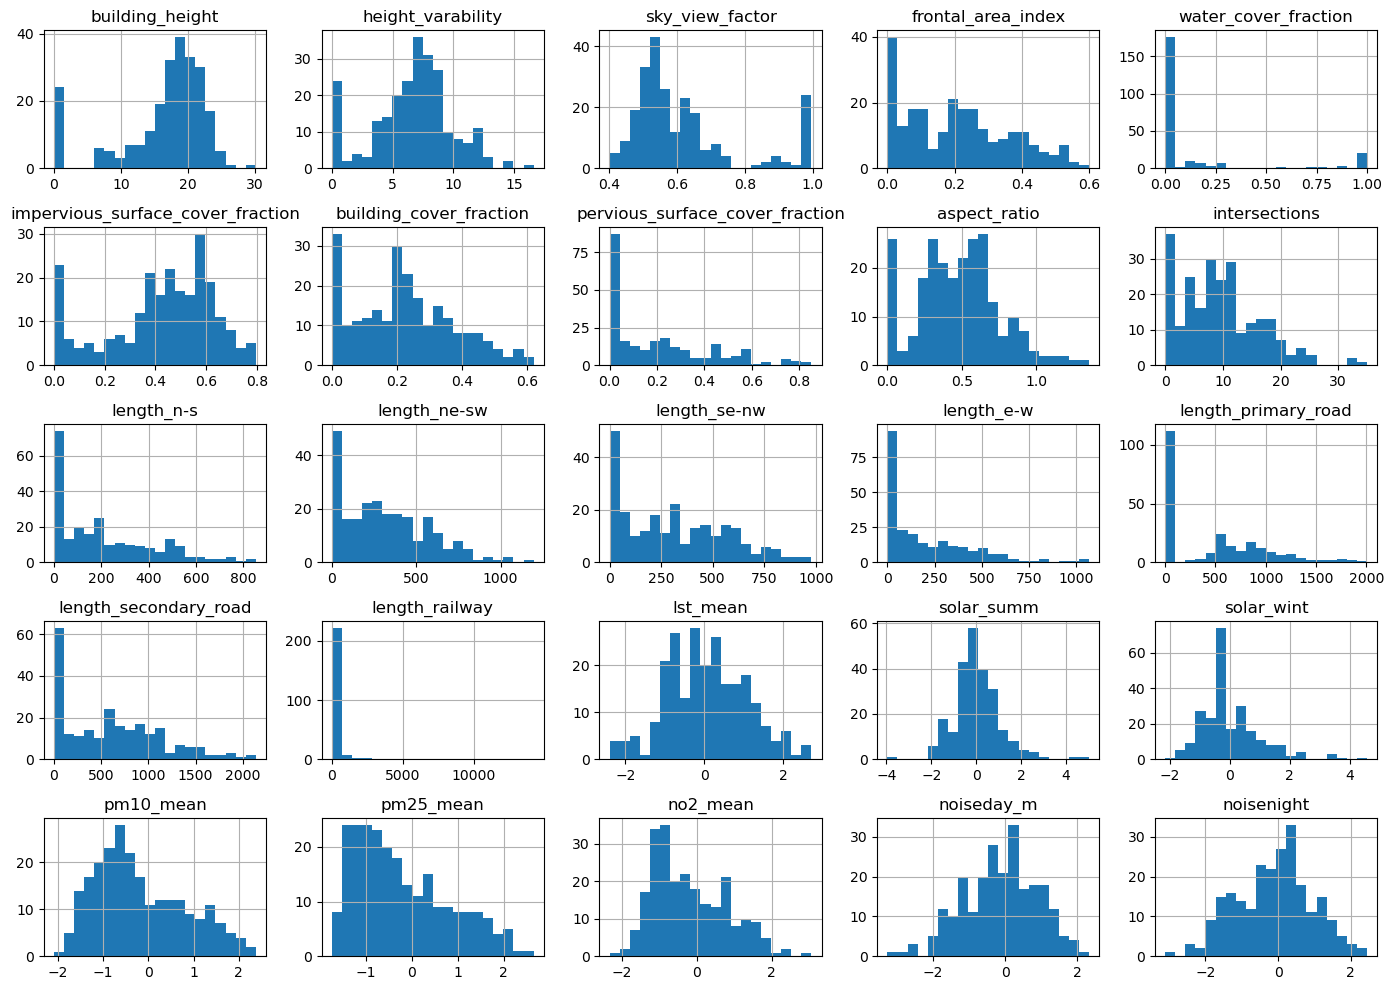

In [15]:
plt.figure(figsize=(12, 8))
df[MORPHOLOGY_FEATURES + EQ_FEATURES].hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

This plot highlights physical coupling of variables related to the morphology of the neighborhoods. Here are some takeaways:

- The "Canyon" Effect: There is a notable negative correlation between building_height and sky_view_factor. As buildings get taller, the visible sky decreases, which physically makes sense.

- Pollutant Clustering: The bottom right corner shows a dense red block among pm10_mean, pm25_mean, and no2_mean. This indicates extremely high multicollinearity. In the regression models, this will make it difficult to determine which specific pollutant is causing a health outcome, as they all move together.

- Morphology Drivers: impervious_surface_cover_fraction correlates positively with temperature (lst_mean), confirming the urban effect where concrete traps heat.

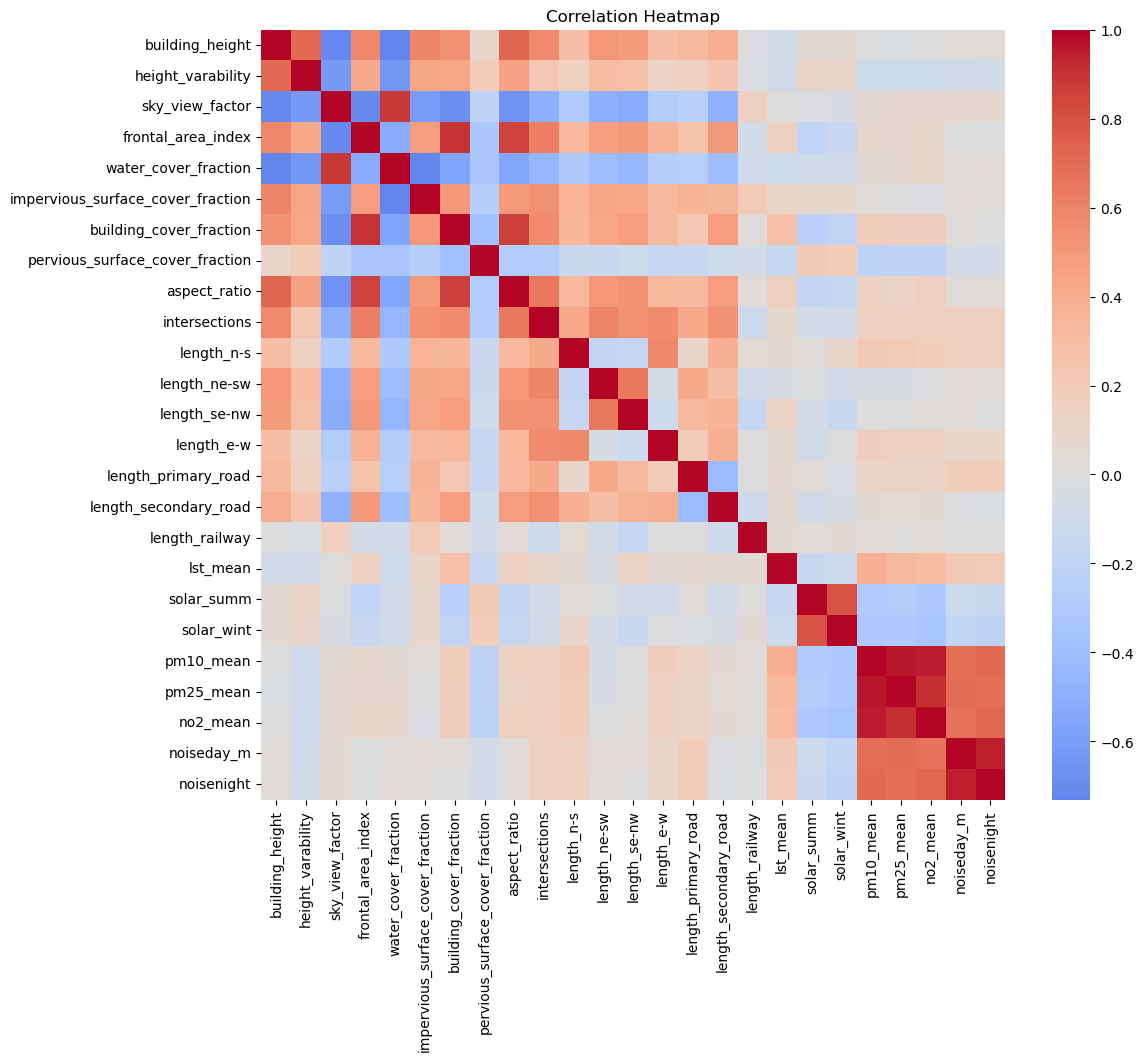

In [16]:
NUMERICAL_MORPHOLOGY_FEATURES = [
    feature for feature in MORPHOLOGY_FEATURES if feature in ALL_CONTINUOUS_FEATURES
]

plt.figure(figsize=(12, 10))
sns.heatmap(
    df[NUMERICAL_MORPHOLOGY_FEATURES + EQ_FEATURES].corr(),
    annot=False,
    cmap="coolwarm",
    center=0,
)
plt.title("Correlation Heatmap")
plt.show()

This confirms the linearity of the relationships seen in the heatmap. The scatter plots between PM10, PM2.5, and NO2 are almost straight lines. This implies that measuring one provides almost all the information needed to predict the other. 

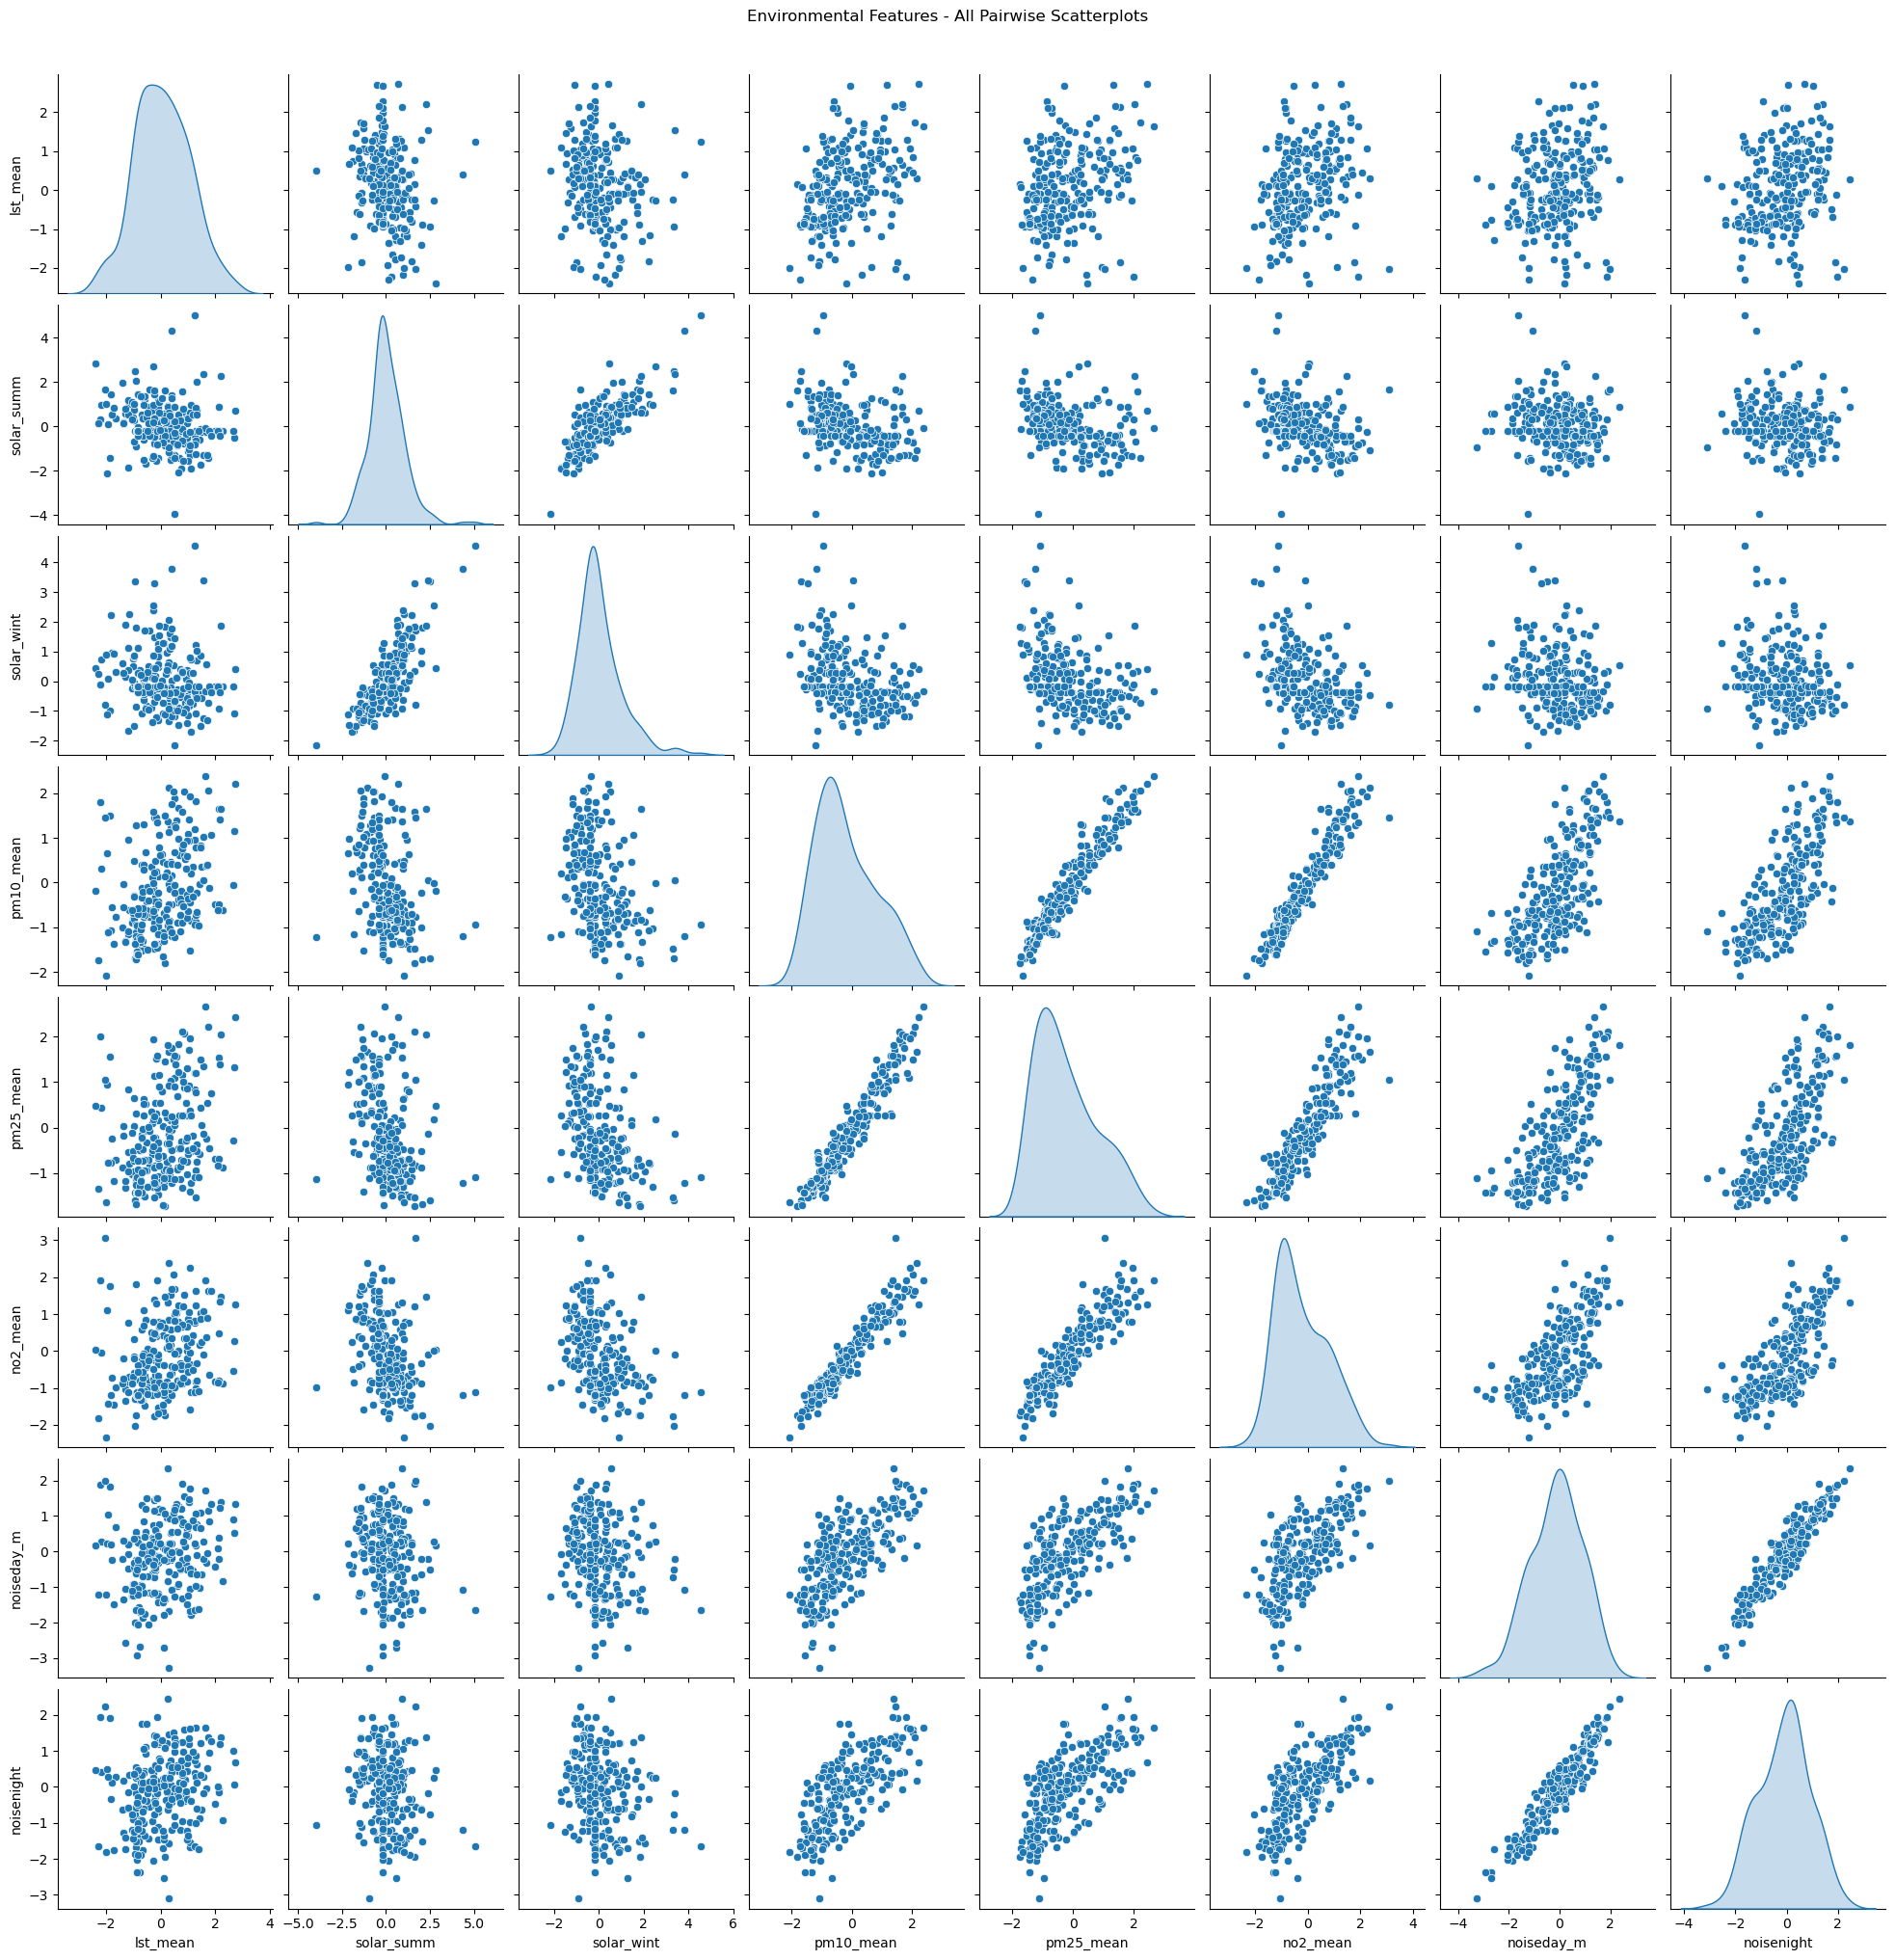

In [17]:
# pairplot for compact visual overview to show all pairwise scatter plots, maybe catch nonlinear relations
sns.pairplot(df[EQ_FEATURES], diag_kind="kde")
plt.suptitle("Environmental Features - All Pairwise Scatterplots", y=1.02)
plt.show()

This serves as a check to validate if the k-means derived typologies (A, B, C... J) are meaningful. In fact, we see that the typologies capture distinct morphological profiles. For example, Typology I is starkly defined by a high `water_cover_fraction` and corresponding low `impervious_surface_cover_fraction`, identifying it as a water-dominated cluster. Similarly, Typology F is uniquely isolated by an extreme outlier in `length_railway`, suggesting it represents transport infrastructure zones.

Also, the inter-quartile ranges for different typologies often do not overlap, indicating clear statistical separation. This confirms that the clustering was computed on the morphological features rather than the environmental outcomes.

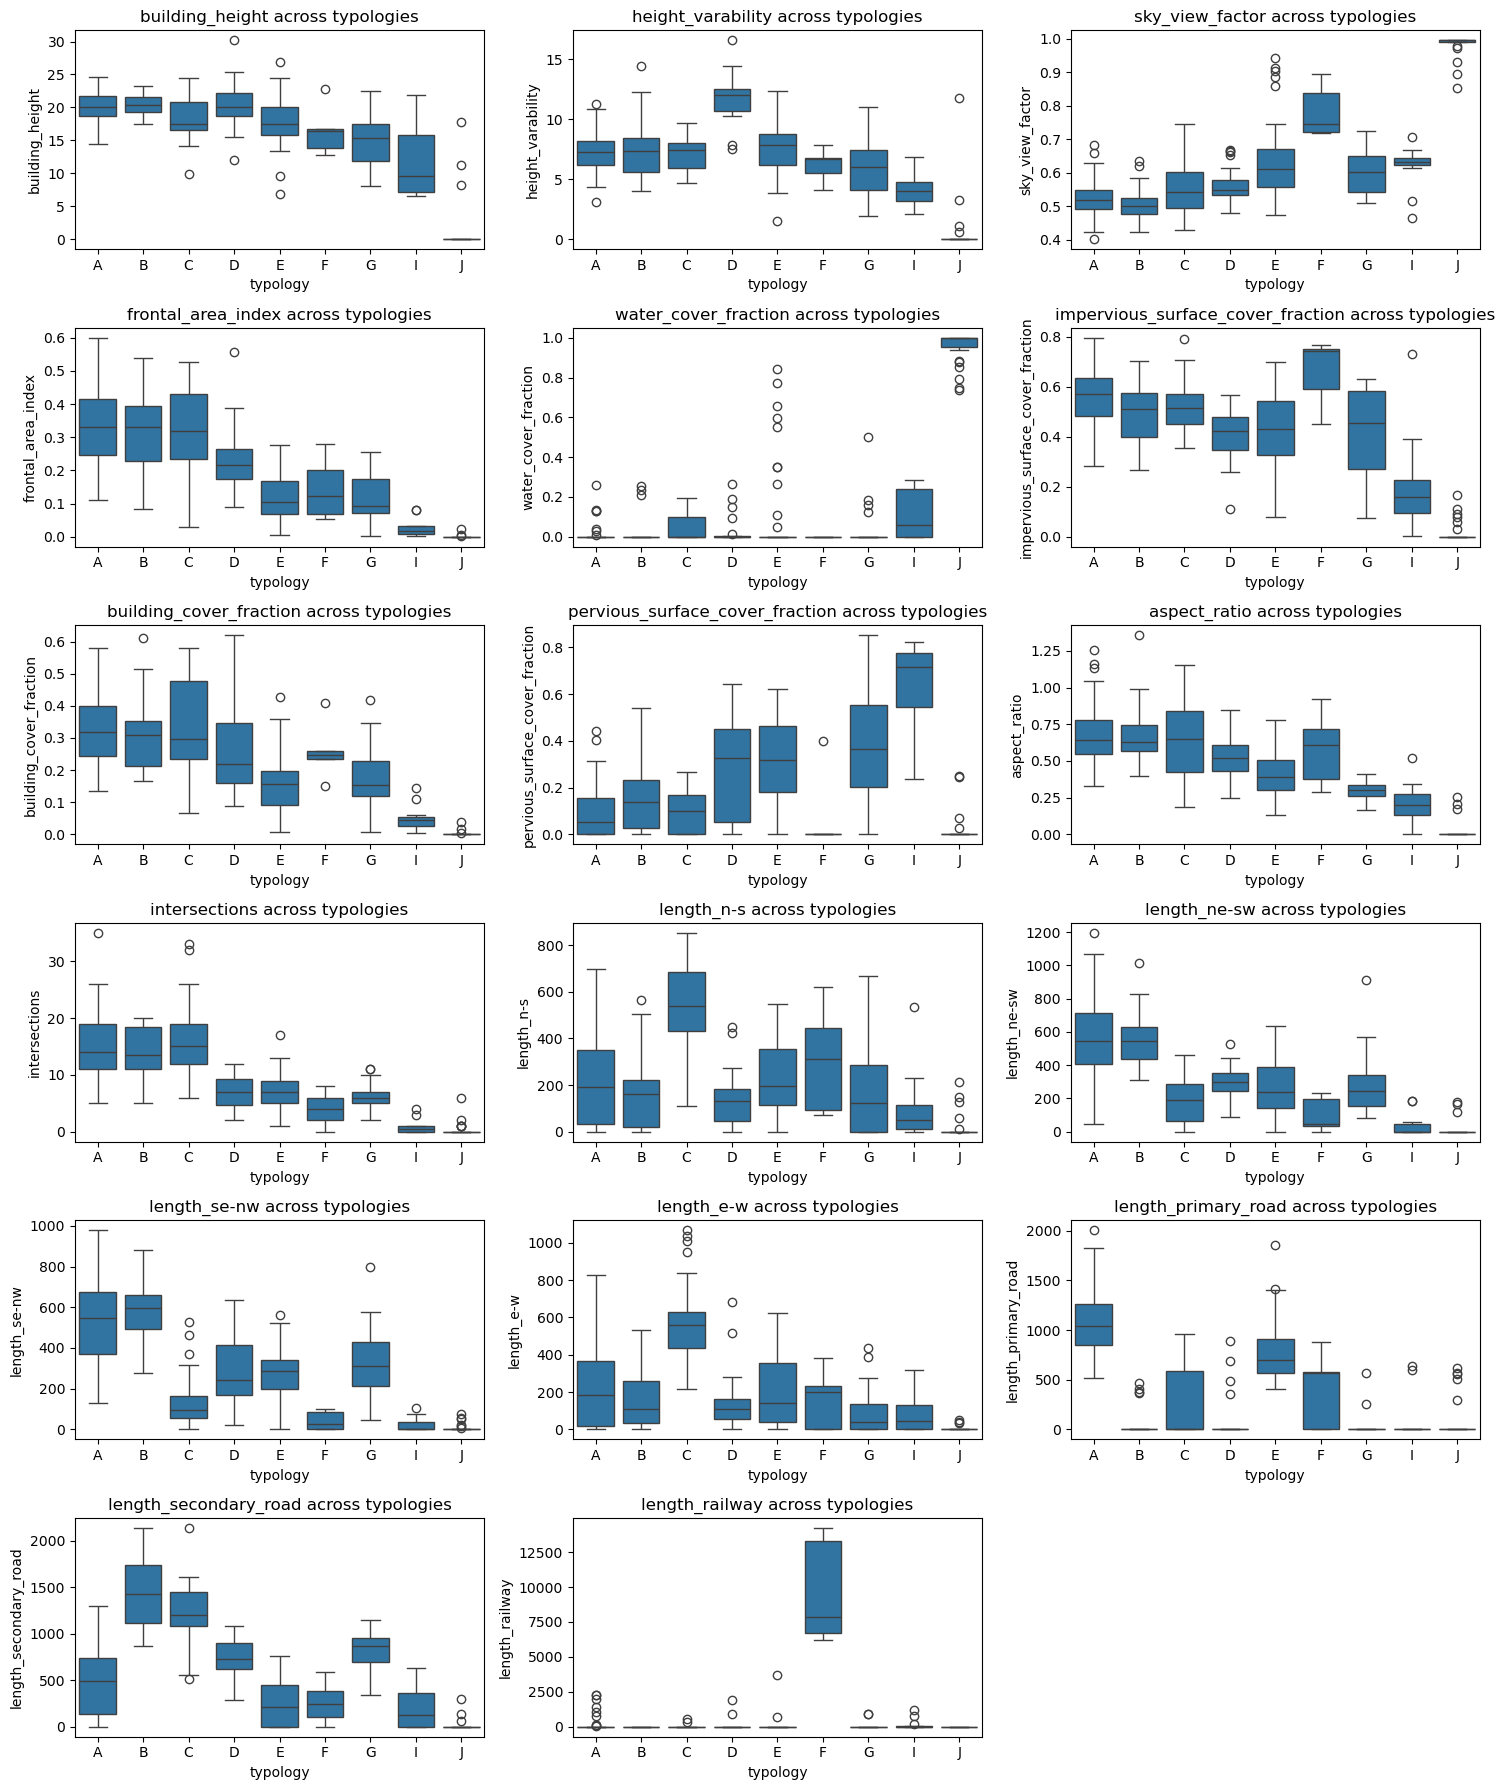

In [18]:
# arrange the env feature boxplots into a single grid of subplots
n = len(NUMERICAL_MORPHOLOGY_FEATURES)
cols = min(3, n)
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3), squeeze=False)
axes_flat = axes.flatten()

for ax, var in zip(axes_flat, NUMERICAL_MORPHOLOGY_FEATURES):
    sns.boxplot(data=df, x="typology", y=var, ax=ax)
    ax.set_title(f"{var} across typologies")
    plt.xticks(rotation=45)

# remove any unused axes (if n < rows*cols)
for ax in axes_flat[len(NUMERICAL_MORPHOLOGY_FEATURES) :]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

In contrast to the previous plots, here we see that for the environmental outcomes (like `lst_mean`, `pm10_mean`, and `noiseday_m`), there is much higher variance within groups and significant overlap between them. While there are visible trends, for instance denser typologies like A and B tend to have slightly higher NO2 means, the distinctions are not sharp. A specific value for `pm25_mean` could plausibly belong to almost any typology.

This confirms that the environmental variables are likely consequences or correlates of the morphological types, rather than the primary drivers used to define the clusters. If the clustering had been driven by temperature or pollution, we would see tight, clearly separated boxes in these environmental charts and likely much more overlap in the morphological ones.

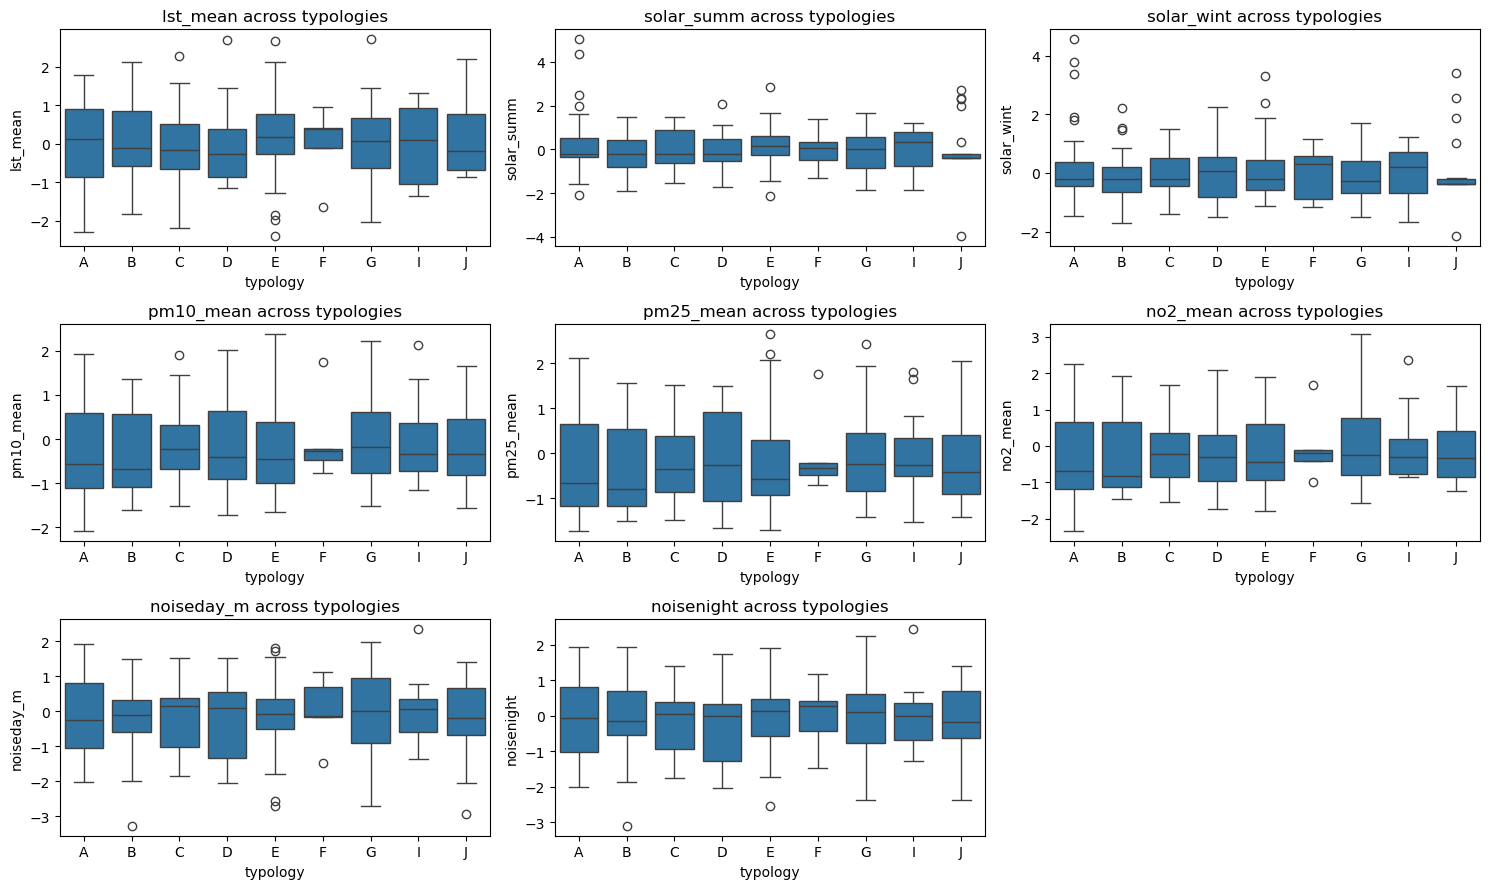

In [19]:
# arrange the env feature boxplots into a single grid of subplots
n = len(EQ_FEATURES)
cols = min(3, n)
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3), squeeze=False)
axes_flat = axes.flatten()

for ax, var in zip(axes_flat, EQ_FEATURES):
    sns.boxplot(data=df, x="typology", y=var, ax=ax)
    ax.set_title(f"{var} across typologies")
    plt.xticks(rotation=45)

# remove any unused axes (if n < rows*cols)
for ax in axes_flat[len(EQ_FEATURES) :]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

PCA components show non-zero mutual correlations, so they are not independent; we will drop them instead of using the PCA basis.

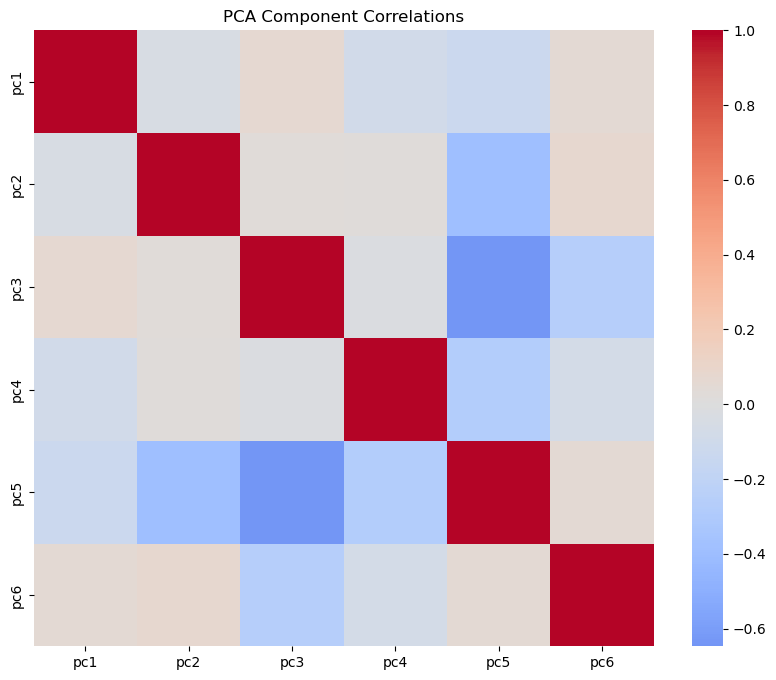

In [20]:
PCA_cols = [col for col in df.columns if col.startswith("pc")]

plt.figure(figsize=(10, 8))
sns.heatmap(
    df[PCA_cols].corr(),
    annot=False,
    cmap="coolwarm",
    center=0,
)
plt.title("PCA Component Correlations")
plt.show()

## 5. Modeling pipeline setup
Load combined morphology + synthetic health data and run preprocessing before feature typing.

In [21]:
# ABLATION STUDY OPTIONS
# Set these to False to disable the corresponding step
ONE_HOT_ENCODING = True
FEATURE_SELECTION = True
STANDARD_SCALING = True
CLASS_BALANCING = True
HYPERPARAMETER_REFINING = True

In [22]:
df = load_combined_dataset(
    data_path / "morphology_data_cleaned.csv",
    data_path / "synthetic_health_data.xlsx",
)
df = run_preprocessing_pipeline(df)
# df = df.sample(frac=0.1, random_state=42).reset_index(
#     drop=True
# )  # shuffle the dataset and reduce it by 90% for quick training

print(f"Final dataset shape: {df.shape}")

Final dataset shape: (11877, 40)


In [23]:
df.head()

,typology,lst_mean,solar_summ,solar_wint,pm10_mean,pm25_mean,no2_mean,noiseday_m,noisenight,building_height,...,heart_failure,heart_rhythm,d_breath_respiratory,d_breath_asthma,GHQ12_score,points_sleep_deprivation,sleep_disorder_hot,sleeping_hours,bedtime_hour,age_bin
0,C,-0.111053,1.130211,0.982144,-1.361464,-1.464034,-1.538696,-1.409763,-1.450883,15.782626,...,0,0,0,0,2,2,0,7.336321,23.716667,5
1,C,-0.111053,1.130211,0.982144,-1.361464,-1.464034,-1.538696,-1.409763,-1.450883,15.782626,...,0,0,1,0,6,6,0,4.779276,20.816667,3
2,C,-0.111053,1.130211,0.982144,-1.361464,-1.464034,-1.538696,-1.409763,-1.450883,15.782626,...,0,0,0,0,2,3,1,9.489910,22.266667,4
3,C,-0.111053,1.130211,0.982144,-1.361464,-1.464034,-1.538696,-1.409763,-1.450883,15.782626,...,0,0,0,0,3,2,1,5.763730,23.450000,6
4,C,-0.111053,1.130211,0.982144,-1.361464,-1.464034,-1.538696,-1.409763,-1.450883,15.782626,...,0,0,0,0,4,3,0,6.465778,22.366667,3


We only have 28 continuous features so we decided not to apply PCA on them. 

In [24]:
print(
    f"Number of features that are continuous: {len([col for col in df.columns if col in ALL_CONTINUOUS_FEATURES and col not in POSSIBLE_TARGET_FEATURES])}",
)

Number of features that are continuous: 28


In [25]:
all_feature_types = {}
for column in df.columns:
    if column in ALL_CONTINUOUS_FEATURES:
        all_feature_types[column] = "continuous"
    elif column in ALL_CATEGORICAL_FEATURES:
        all_feature_types[column] = "categorical"
    elif column in ALL_BINARY_FEATURES:
        all_feature_types[column] = "binary"
    else:
        non_null_values = df[column].dropna()
        if not non_null_values.empty and non_null_values.isin([0, 1]).all():
            all_feature_types[column] = "binary"
        else:
            all_feature_types[column] = "continuous"

## 6. Feature selection per target
Aggregate health targets, test associations, apply p-value and VIF filters, and persist cleaned feature sets.

Each health outcome will have its own trimmed dataset with only the useful predictors (after p-values, VIF, and one-hot encoding).

In [26]:
datasets = {
    "cardiovascular": aggregate_health_targets(
        df, target_feature="cardiovascular", feature_types=all_feature_types
    ),
    "mental_health": aggregate_health_targets(
        df, target_feature="mental_health", feature_types=all_feature_types
    ),
    "sleep_disorder": aggregate_health_targets(
        df, target_feature="sleep_disorder", feature_types=all_feature_types
    ),
    "respiratory": aggregate_health_targets(
        df, target_feature="respiratory", feature_types=all_feature_types
    ),
}

In [27]:
for name, dataset_with_info in datasets.items():
    print(f"\n=== Analyzing target type: {name} ===")

    dataset = dataset_with_info["data"]
    feature_types = dataset_with_info["feature_types"]

    if not FEATURE_SELECTION:
        # Optional OHE even when skipping feature selection
        dataset, feature_types = ohe_features(
            dataset,
            feature_types,
            enable=ONE_HOT_ENCODING,
        )
        print(
            "Feature selection disabled: retaining all predictors without p-value/VIF filtering."
        )
        print("\nSelected features:")
        print([col for col in dataset.columns if col != "target"])
        datasets[name]["data"] = dataset
        datasets[name]["feature_types"] = feature_types
        continue

    # compute associations for categorical features before one-hot encoding
    categorical_association_df = compute_categorical_associations(
        dataset,
        "target",
        feature_types,
    )
    if categorical_association_df is not None and not categorical_association_df.empty:
        display(categorical_association_df)

        # keep categorical predictors that are significant
        passed_by_p = filter_by_p_value(categorical_association_df)

        dropped_categorical_features = [
            feature
            for feature in dataset.columns
            if feature in ALL_CATEGORICAL_FEATURES and feature not in passed_by_p
        ]

        dataset, feature_types = drop_features(
            dataset,
            feature_types,
            dropped_categorical_features,
        )
        print(
            f"Categorical features dropped because they did not pass p-value thresholds: \n {dropped_categorical_features}"
        )

    # one hot encoding of categorical features
    dataset, feature_types = ohe_features(
        dataset,
        feature_types,
        enable=ONE_HOT_ENCODING,
    )

    # compute all association tests
    association_df = compute_associations(
        dataset,
        "target",
        feature_types,
    )

    # filter out features that are not significant in any of our association tests
    passed_by_p = filter_by_p_value(association_df)
    feature_names_to_keep = set(passed_by_p)

    dropped_features_by_p_value = [
        feature
        for feature in dataset.columns
        if feature not in feature_names_to_keep and feature != "target"
    ]
    dataset, feature_types = drop_features(
        dataset,
        feature_types,
        dropped_features_by_p_value,
    )
    print(
        f"Features dropped because they did not pass p-value thresholds: \n {dropped_features_by_p_value}"
    )

    vif_df = pd.DataFrame(compute_vif(dataset, feature_types))
    if not vif_df.empty:
        vif_df = vif_df.sort_values(by="statistic_value", ascending=False)

        passed_by_vif = set(filter_by_vif(vif_df))
        dropped_features_by_VIF = [
            feature
            for feature, ftype in feature_types.items()
            if ftype == "continuous"
            and feature not in passed_by_vif
            and feature != "target"
        ]
        dataset, feature_types = drop_features(
            dataset,
            feature_types,
            dropped_features_by_VIF,
        )
        print(
            f"Features dropped because they did not pass VIF thresholds: \n {dropped_features_by_VIF}"
        )
    else:
        print(
            "Skipped VIF step: no continuous features or insufficient data; nothing dropped."
        )

    print("\nSelected features:")
    selected_features = [col for col in dataset.columns if col != "target"]
    print(selected_features)
    print()

    # Save changes to dataset
    datasets[name]["data"] = dataset
    datasets[name]["feature_types"] = feature_types

    for test_name, subset in association_df.groupby("test", sort=False):
        print(f"\nTest: {test_name}")
        display(subset.reset_index(drop=True))

    if vif_df is not None and vif_df.empty is False:
        print(f"\nTest: VIF")
        display(
            vif_df.drop(columns=["p_value"], errors="ignore").reset_index(drop=True)
        )


=== Analyzing target type: cardiovascular ===


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,neighbourhood_type,categorical,Chi-square,chi2,5.108211,0.883833
1,typology,categorical,Chi-square,chi2,2.808973,0.945767


Categorical features dropped because they did not pass p-value thresholds: 
 ['typology', 'neighbourhood_type']
Features dropped because they did not pass p-value thresholds: 
 ['lst_mean', 'solar_summ', 'solar_wint', 'building_height', 'height_varability', 'frontal_area_index', 'impervious_surface_cover_fraction', 'building_cover_fraction', 'aspect_ratio', 'intersections', 'length_n-s', 'length_ne-sw', 'length_e-w', 'length_primary_road', 'length_secondary_road', 'sex', 'education_level']
Features dropped because they did not pass VIF thresholds: 
 []

Selected features:
['pm10_mean', 'pm25_mean', 'no2_mean', 'noiseday_m', 'noisenight', 'sky_view_factor', 'water_cover_fraction', 'pervious_surface_cover_fraction', 'length_se-nw', 'length_railway', 'income', 'age_bin']


Test: Univariate logistic regression


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,age_bin,continuous,Univariate logistic regression,odds_ratio,1.514138,4.361712e-31
1,noisenight,continuous,Univariate logistic regression,odds_ratio,1.081876,1.978266e-02
2,no2_mean,continuous,Univariate logistic regression,odds_ratio,1.078352,2.821518e-02
3,pervious_surface_cover_fraction,continuous,Univariate logistic regression,odds_ratio,0.722244,4.216330e-02
4,noiseday_m,continuous,Univariate logistic regression,odds_ratio,1.071216,4.244863e-02
5,pm10_mean,continuous,Univariate logistic regression,odds_ratio,1.069873,4.961614e-02
6,pm25_mean,continuous,Univariate logistic regression,odds_ratio,1.060624,8.258990e-02
7,sky_view_factor,continuous,Univariate logistic regression,odds_ratio,1.295083,2.278467e-01
8,length_railway,continuous,Univariate logistic regression,odds_ratio,1.000023,2.820037e-01
9,length_se-nw,continuous,Univariate logistic regression,odds_ratio,0.999869,3.574067e-01



Test: Chi-square


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,sex,binary,Chi-square,chi2,0.000079,0.992921



Test: VIF


,predictor,predictor_type,test,statistic_name,statistic_value
0,pm10_mean,continuous,VIF,VIF,27.166995
1,pm25_mean,continuous,VIF,VIF,13.688014
2,no2_mean,continuous,VIF,VIF,13.521891
3,noisenight,continuous,VIF,VIF,11.501790
4,noiseday_m,continuous,VIF,VIF,10.773214
5,water_cover_fraction,continuous,VIF,VIF,8.068533
6,sky_view_factor,continuous,VIF,VIF,7.079438
7,length_se-nw,continuous,VIF,VIF,1.572050
8,length_railway,continuous,VIF,VIF,1.558447
9,pervious_surface_cover_fraction,continuous,VIF,VIF,1.555329



=== Analyzing target type: mental_health ===


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,typology,categorical,ANOVA,F,0.37845,0.932590
1,neighbourhood_type,categorical,ANOVA,F,0.35686,0.964694


Categorical features dropped because they did not pass p-value thresholds: 
 ['typology', 'neighbourhood_type']
Features dropped because they did not pass p-value thresholds: 
 ['solar_summ', 'solar_wint', 'pm25_mean', 'noisenight', 'building_height', 'height_varability', 'length_se-nw', 'length_e-w', 'length_railway']
Features dropped because they did not pass VIF thresholds: 
 ['water_cover_fraction', 'impervious_surface_cover_fraction', 'building_cover_fraction', 'pervious_surface_cover_fraction']

Selected features:
['lst_mean', 'pm10_mean', 'no2_mean', 'noiseday_m', 'sky_view_factor', 'frontal_area_index', 'aspect_ratio', 'intersections', 'length_n-s', 'length_ne-sw', 'length_primary_road', 'length_secondary_road', 'sex', 'income', 'education_level', 'age_bin']


Test: Univariate linear regression


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,income,continuous,Univariate linear regression,coef[income],-3.674430e-02,7.914573e-36
1,length_secondary_road,continuous,Univariate linear regression,coef[length_secondary_road],-1.036720e-05,7.114867e-02
2,age_bin,continuous,Univariate linear regression,coef[age_bin],-4.964748e-03,7.432885e-02
3,education_level,continuous,Univariate linear regression,coef[education_level],-5.742179e-03,1.715210e-01
4,aspect_ratio,continuous,Univariate linear regression,coef[aspect_ratio],-1.323240e-02,2.262093e-01
5,building_cover_fraction,continuous,Univariate linear regression,coef[building_cover_fraction],-2.266989e-02,2.439287e-01
6,frontal_area_index,continuous,Univariate linear regression,coef[frontal_area_index],-2.060712e-02,2.771519e-01
7,no2_mean,continuous,Univariate linear regression,coef[no2_mean],-3.180603e-03,2.816720e-01
8,pm10_mean,continuous,Univariate linear regression,coef[pm10_mean],-3.137672e-03,2.874864e-01
9,impervious_surface_cover_fraction,continuous,Univariate linear regression,coef[impervious_surface_cover_fraction],-1.387018e-02,3.210850e-01



Test: Pearson correlation


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,income,continuous,Pearson correlation,r,-0.114292,7.914573e-36
1,length_secondary_road,continuous,Pearson correlation,r,-0.016559,7.114867e-02
2,age_bin,continuous,Pearson correlation,r,-0.016376,7.432885e-02
3,education_level,continuous,Pearson correlation,r,-0.012547,1.715210e-01
4,aspect_ratio,continuous,Pearson correlation,r,-0.011105,2.262093e-01
5,building_cover_fraction,continuous,Pearson correlation,r,-0.010693,2.439287e-01
6,frontal_area_index,continuous,Pearson correlation,r,-0.009973,2.771519e-01
7,no2_mean,continuous,Pearson correlation,r,-0.009879,2.816720e-01
8,pm10_mean,continuous,Pearson correlation,r,-0.009761,2.874864e-01
9,impervious_surface_cover_fraction,continuous,Pearson correlation,r,-0.009105,3.210850e-01



Test: Spearman correlation


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,income,continuous,Spearman correlation,rho,-0.113250,3.324539e-35
1,age_bin,continuous,Spearman correlation,rho,-0.018254,4.667281e-02
2,length_secondary_road,continuous,Spearman correlation,rho,-0.015443,9.239242e-02
3,education_level,continuous,Spearman correlation,rho,-0.012516,1.726078e-01
4,aspect_ratio,continuous,Spearman correlation,rho,-0.012034,1.897106e-01
5,no2_mean,continuous,Spearman correlation,rho,-0.011453,2.120052e-01
6,length_primary_road,continuous,Spearman correlation,rho,0.010914,2.343221e-01
7,building_cover_fraction,continuous,Spearman correlation,rho,-0.010849,2.371063e-01
8,lst_mean,continuous,Spearman correlation,rho,-0.010427,2.558684e-01
9,pm10_mean,continuous,Spearman correlation,rho,-0.010368,2.585305e-01



Test: Point-biserial correlation


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,sex,binary,Point-biserial correlation,r_pb,-0.00769,0.402007



Test: VIF


,predictor,predictor_type,test,statistic_name,statistic_value
0,water_cover_fraction,continuous,VIF,VIF,6351.096639
1,pervious_surface_cover_fraction,continuous,VIF,VIF,3169.472278
2,impervious_surface_cover_fraction,continuous,VIF,VIF,2801.370265
3,building_cover_fraction,continuous,VIF,VIF,1458.654833
4,pm10_mean,continuous,VIF,VIF,14.992170
5,no2_mean,continuous,VIF,VIF,13.227545
6,length_secondary_road,continuous,VIF,VIF,10.535285
7,sky_view_factor,continuous,VIF,VIF,9.429049
8,length_primary_road,continuous,VIF,VIF,8.660021
9,frontal_area_index,continuous,VIF,VIF,8.127670



=== Analyzing target type: sleep_disorder ===


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,typology,categorical,ANOVA,F,0.96276,0.463155
1,neighbourhood_type,categorical,ANOVA,F,0.66281,0.759991


Categorical features dropped because they did not pass p-value thresholds: 
 ['neighbourhood_type']
Features dropped because they did not pass p-value thresholds: 
 ['lst_mean', 'noiseday_m', 'aspect_ratio', 'intersections', 'length_n-s', 'length_se-nw', 'length_e-w', 'length_secondary_road', 'length_railway', 'typology_B', 'typology_D', 'typology_F', 'typology_G']
Features dropped because they did not pass VIF thresholds: 
 ['water_cover_fraction', 'impervious_surface_cover_fraction', 'building_cover_fraction', 'pervious_surface_cover_fraction']

Selected features:
['solar_summ', 'solar_wint', 'pm10_mean', 'pm25_mean', 'no2_mean', 'noisenight', 'building_height', 'height_varability', 'sky_view_factor', 'frontal_area_index', 'length_ne-sw', 'length_primary_road', 'sex', 'income', 'education_level', 'age_bin', 'typology_A', 'typology_C', 'typology_E', 'typology_I', 'typology_J']


Test: Spearman correlation


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,income,continuous,Spearman correlation,rho,-0.018155,0.047871
1,education_level,continuous,Spearman correlation,rho,0.013890,0.130116
2,pervious_surface_cover_fraction,continuous,Spearman correlation,rho,0.013323,0.146523
3,age_bin,continuous,Spearman correlation,rho,-0.012917,0.159231
4,height_varability,continuous,Spearman correlation,rho,0.010044,0.273726
5,no2_mean,continuous,Spearman correlation,rho,-0.009215,0.315274
6,building_cover_fraction,continuous,Spearman correlation,rho,-0.008419,0.358904
7,pm10_mean,continuous,Spearman correlation,rho,-0.008177,0.372902
8,length_ne-sw,continuous,Spearman correlation,rho,0.007776,0.396787
9,water_cover_fraction,continuous,Spearman correlation,rho,-0.007741,0.398900



Test: Point-biserial correlation


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,typology_E,binary,Point-biserial correlation,r_pb,0.016695,0.068847
1,typology_J,binary,Point-biserial correlation,r_pb,-0.013932,0.128946
2,typology_I,binary,Point-biserial correlation,r_pb,-0.010802,0.239156
3,typology_C,binary,Point-biserial correlation,r_pb,-0.009235,0.314242
4,sex,binary,Point-biserial correlation,r_pb,0.007999,0.383397
5,typology_A,binary,Point-biserial correlation,r_pb,0.006657,0.468167
6,typology_G,binary,Point-biserial correlation,r_pb,0.004236,0.644397
7,typology_F,binary,Point-biserial correlation,r_pb,-0.002407,0.793125
8,typology_B,binary,Point-biserial correlation,r_pb,-0.001967,0.830239
9,typology_D,binary,Point-biserial correlation,r_pb,-0.000953,0.917285



Test: Univariate linear regression


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,typology_E,binary,Univariate linear regression,coef[typology_E],1.045513e-02,0.068847
1,height_varability,continuous,Univariate linear regression,coef[height_varability],1.209228e-03,0.073367
2,length_ne-sw,continuous,Univariate linear regression,coef[length_ne-sw],1.424014e-05,0.102674
3,typology_J,binary,Univariate linear regression,coef[typology_J],-1.056536e-02,0.128946
4,education_level,continuous,Univariate linear regression,coef[education_level],4.774067e-03,0.132254
5,solar_wint,continuous,Univariate linear regression,coef[solar_wint],3.234783e-03,0.152044
6,length_primary_road,continuous,Univariate linear regression,coef[length_primary_road],5.699047e-06,0.189868
7,income,continuous,Univariate linear regression,coef[income],-2.678859e-03,0.229239
8,solar_summ,continuous,Univariate linear regression,coef[solar_summ],2.656369e-03,0.235915
9,water_cover_fraction,continuous,Univariate linear regression,coef[water_cover_fraction],-8.268111e-03,0.238179



Test: Pearson correlation


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,height_varability,continuous,Pearson correlation,r,0.016430,0.073367
1,length_ne-sw,continuous,Pearson correlation,r,0.014976,0.102674
2,education_level,continuous,Pearson correlation,r,0.013813,0.132254
3,solar_wint,continuous,Pearson correlation,r,0.013144,0.152044
4,length_primary_road,continuous,Pearson correlation,r,0.012030,0.189868
5,income,continuous,Pearson correlation,r,-0.011033,0.229239
6,solar_summ,continuous,Pearson correlation,r,0.010877,0.235915
7,water_cover_fraction,continuous,Pearson correlation,r,-0.010824,0.238179
8,pervious_surface_cover_fraction,continuous,Pearson correlation,r,0.009585,0.296233
9,pm25_mean,continuous,Pearson correlation,r,-0.009143,0.319095



Test: VIF


,predictor,predictor_type,test,statistic_name,statistic_value
0,water_cover_fraction,continuous,VIF,VIF,6323.888924
1,pervious_surface_cover_fraction,continuous,VIF,VIF,3154.540777
2,impervious_surface_cover_fraction,continuous,VIF,VIF,2784.767120
3,building_cover_fraction,continuous,VIF,VIF,1452.680396
4,pm10_mean,continuous,VIF,VIF,28.953010
5,no2_mean,continuous,VIF,VIF,13.653740
6,pm25_mean,continuous,VIF,VIF,13.182474
7,sky_view_factor,continuous,VIF,VIF,8.195504
8,frontal_area_index,continuous,VIF,VIF,7.607077
9,building_height,continuous,VIF,VIF,3.612429



=== Analyzing target type: respiratory ===


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,neighbourhood_type,categorical,Chi-square,chi2,10.371355,0.408539
1,typology,categorical,Chi-square,chi2,5.953962,0.652389


Categorical features dropped because they did not pass p-value thresholds: 
 ['typology']
Features dropped because they did not pass p-value thresholds: 
 ['lst_mean', 'solar_summ', 'solar_wint', 'pm10_mean', 'pm25_mean', 'no2_mean', 'noiseday_m', 'building_height', 'height_varability', 'sky_view_factor', 'water_cover_fraction', 'building_cover_fraction', 'pervious_surface_cover_fraction', 'aspect_ratio', 'intersections', 'length_n-s', 'length_ne-sw', 'length_se-nw', 'length_secondary_road', 'length_railway', 'sex', 'income', 'education_level', 'neighbourhood_type_G-B', 'neighbourhood_type_G-D', 'neighbourhood_type_G-F', 'neighbourhood_type_S-D', 'neighbourhood_type_S-E']
Features dropped because they did not pass VIF thresholds: 
 []

Selected features:
['noisenight', 'frontal_area_index', 'impervious_surface_cover_fraction', 'length_e-w', 'length_primary_road', 'age_bin', 'neighbourhood_type_G-A', 'neighbourhood_type_G-C', 'neighbourhood_type_G-E', 'neighbourhood_type_S-A', 'neighbou

,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,age_bin,continuous,Univariate logistic regression,odds_ratio,1.118048,0.000007
1,neighbourhood_type_S-B,binary,Univariate logistic regression,odds_ratio,0.807925,0.015429
2,impervious_surface_cover_fraction,continuous,Univariate logistic regression,odds_ratio,0.842939,0.162395
3,neighbourhood_type_S-C,binary,Univariate logistic regression,odds_ratio,0.916363,0.229588
4,length_primary_road,continuous,Univariate logistic regression,odds_ratio,0.999945,0.279449
5,neighbourhood_type_G-C,binary,Univariate logistic regression,odds_ratio,1.120522,0.309289
6,length_e-w,continuous,Univariate logistic regression,odds_ratio,0.999878,0.309797
7,neighbourhood_type_G-A,binary,Univariate logistic regression,odds_ratio,1.097105,0.340917
8,neighbourhood_type_G-E,binary,Univariate logistic regression,odds_ratio,1.058969,0.437057
9,noisenight,continuous,Univariate logistic regression,odds_ratio,1.019278,0.445466



Test: Chi-square


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,neighbourhood_type_S-B,binary,Chi-square,chi2,5.687074,0.017090
1,neighbourhood_type_S-C,binary,Chi-square,chi2,1.359929,0.243550
2,neighbourhood_type_G-C,binary,Chi-square,chi2,0.920193,0.337424
3,neighbourhood_type_G-A,binary,Chi-square,chi2,0.814787,0.366709
4,neighbourhood_type_G-E,binary,Chi-square,chi2,0.547401,0.459382
5,neighbourhood_type_S-A,binary,Chi-square,chi2,0.488279,0.484696
6,neighbourhood_type_G-D,binary,Chi-square,chi2,0.359794,0.548621
7,neighbourhood_type_S-E,binary,Chi-square,chi2,0.195876,0.658071
8,neighbourhood_type_S-D,binary,Chi-square,chi2,0.155946,0.692917
9,neighbourhood_type_G-B,binary,Chi-square,chi2,0.121388,0.727534



Test: VIF


,predictor,predictor_type,test,statistic_name,statistic_value
0,frontal_area_index,continuous,VIF,VIF,1.440089
1,impervious_surface_cover_fraction,continuous,VIF,VIF,1.439730
2,length_primary_road,continuous,VIF,VIF,1.225354
3,length_e-w,continuous,VIF,VIF,1.217776
4,noisenight,continuous,VIF,VIF,1.050038
5,age_bin,continuous,VIF,VIF,1.000484


## 7. Run predictive modeling suite
Train regression/classification models per target, capture metrics, coefficients, residuals, and confusion matrices. This corresponds to the supervised-learning stage outlined in the study: EQ variables (temperature, solar access, air/noise pollution) plus morphology feed separate models for cardiovascular, respiratory, sleep/circadian, and mental-health targets. Demographic/socioeconomic controls remain in the feature space to reduce confounding, and model interpretability (coefficients/importances) is used to flag the most influential EQ factors per health dimension.

In [28]:
# Initialize lists to store results
all_regression_results = []
all_classification_results = []
all_coefficients = []

# Initialize dictionaries for plots and best estimators
all_residual_plots = {}
all_confusion_matrices = {}
best_models = {}

print("Running Predictive Modeling Suite for All Datasets\n")

for name, dataset_with_info in datasets.items():
    print(f"Processing: {name.upper()}...")

    dataset = dataset_with_info["data"]
    feature_types = dataset_with_info["feature_types"]
    target_type = feature_types["target"]

    model_results = run_modeling_suite(
        dataset,
        "target",
        feature_types=feature_types,
        imbalance_strategy=(
            ("sample_weight" if target_type == "continuous" else "class_weight")
            if CLASS_BALANCING
            else "none"
        ),
        use_standard_scaling=STANDARD_SCALING,
        refine_hyperparameters=HYPERPARAMETER_REFINING,
        enable_ohe=ONE_HOT_ENCODING,
        dataset_name=name,
    )

    coef_df = model_results.get("coefficients", pd.DataFrame())
    best_models[name] = model_results.get("best_model_fitted")

    if target_type == "continuous":
        # Collect Regression Results
        reg_df = model_results.get("regression_results", pd.DataFrame())
        if not reg_df.empty:
            reg_df["Dataset"] = name.upper()
            all_regression_results.append(reg_df)

        # Collect Coefficients (regression)
        if not coef_df.empty:
            coef_df["Dataset"] = name.upper()
            all_coefficients.append(coef_df)

        # Collect Residual Plots
        residuals = model_results.get("residuals", {})
        if residuals:
            all_residual_plots[name] = residuals

    else:
        # Collect Classification Results
        clf_df = model_results.get("classification_results", pd.DataFrame())
        if not clf_df.empty:
            clf_df["Dataset"] = name.upper()
            all_classification_results.append(clf_df)

        # Collect Coefficients (classification)
        if not coef_df.empty:
            coef_df["Dataset"] = name.upper()
            all_coefficients.append(coef_df)

        # Collect Confusion Matrices
        cms = model_results.get("confusion_matrices", {})
        if cms:
            all_confusion_matrices[name] = cms

Running Predictive Modeling Suite for All Datasets

Processing: CARDIOVASCULAR...
Processing: MENTAL_HEALTH...
Processing: SLEEP_DISORDER...
Processing: RESPIRATORY...


In [29]:
# --- Display Summary Results ---

final_reg_df = pd.DataFrame()
final_clf_df = pd.DataFrame()
final_coef_df = pd.DataFrame()

if all_regression_results:
    final_reg_df = pd.concat(all_regression_results, ignore_index=True)
    cols = ["Dataset"] + [c for c in final_reg_df.columns if c != "Dataset"]
    final_reg_df = final_reg_df[cols]

if all_classification_results:
    final_clf_df = pd.concat(all_classification_results, ignore_index=True)
    cols = ["Dataset"] + [c for c in final_clf_df.columns if c != "Dataset"]
    final_clf_df = final_clf_df[cols]

if all_coefficients:
    final_coef_df = pd.concat(all_coefficients, ignore_index=True)
    cols = ["Dataset"] + [c for c in final_coef_df.columns if c != "Dataset"]
    final_coef_df = final_coef_df[cols]

# Per-dataset ordered view: results first, then coefficients
if not (final_reg_df.empty and final_clf_df.empty and final_coef_df.empty):
    print(f"PER-DATASET RESULTS AND COEFFICIENTS")
    for dataset_name in [name.upper() for name in datasets.keys()]:
        print(f"\nDataset: {dataset_name}")
        reg_subset = (
            final_reg_df[final_reg_df["Dataset"] == dataset_name]
            if not final_reg_df.empty
            else pd.DataFrame()
        )
        if not reg_subset.empty:
            print("  Regression results:")
            display(reg_subset)
        clf_subset = (
            final_clf_df[final_clf_df["Dataset"] == dataset_name]
            if not final_clf_df.empty
            else pd.DataFrame()
        )
        if not clf_subset.empty:
            print("  Classification results:")
            display(clf_subset)
        coef_subset = (
            final_coef_df[final_coef_df["Dataset"] == dataset_name]
            if not final_coef_df.empty
            else pd.DataFrame()
        )
        if not coef_subset.empty:
            print("  Coefficients / importances:")
            display(coef_subset)

PER-DATASET RESULTS AND COEFFICIENTS

Dataset: CARDIOVASCULAR
  Classification results:


,Dataset,Accuracy,Precision,Recall,F1,ROC_AUC,model,best_params,threshold
0,CARDIOVASCULAR,0.607744,0.110766,0.594444,0.186736,0.622149,Logistic Regression (Lasso),{'model__C': 0.008},0.513942
1,CARDIOVASCULAR,0.723485,0.115942,0.400000,0.179775,0.604536,SVM (Linear),{'model__C': 0.008},0.080411
2,CARDIOVASCULAR,0.707492,0.113943,0.422222,0.179457,0.624287,Logistic Regression (Ridge),{'model__C': 0.008},0.556606
3,CARDIOVASCULAR,0.539983,0.102698,0.655556,0.177577,0.626746,SVM (RBF),"{'model__C': 0.08000000000000002, 'model__gamm...",0.073977
4,CARDIOVASCULAR,0.385522,0.087097,0.750000,0.156069,0.589924,Random Forest Classifier,"{'model__max_depth': 8, 'model__n_estimators':...",0.353092
5,CARDIOVASCULAR,0.075758,0.075758,1.000000,0.140845,0.492259,k-NN Classifier,{'model__n_neighbors': 1},0.000000


  Coefficients / importances:


,Dataset,model,feature,coefficient
0,CARDIOVASCULAR,Logistic Regression (Lasso),pm10_mean,0.000000
1,CARDIOVASCULAR,Logistic Regression (Lasso),pm25_mean,0.000000
2,CARDIOVASCULAR,Logistic Regression (Lasso),no2_mean,0.011760
3,CARDIOVASCULAR,Logistic Regression (Lasso),noiseday_m,0.000000
4,CARDIOVASCULAR,Logistic Regression (Lasso),noisenight,0.035294
5,CARDIOVASCULAR,Logistic Regression (Lasso),sky_view_factor,0.002859
6,CARDIOVASCULAR,Logistic Regression (Lasso),water_cover_fraction,0.000000
7,CARDIOVASCULAR,Logistic Regression (Lasso),pervious_surface_cover_fraction,0.029372
8,CARDIOVASCULAR,Logistic Regression (Lasso),length_se-nw,0.005495
9,CARDIOVASCULAR,Logistic Regression (Lasso),length_railway,0.000000



Dataset: MENTAL_HEALTH
  Regression results:


,Dataset,model,RMSE,MAE,R2,best_params
0,MENTAL_HEALTH,Lasso Regression,0.321674,0.284253,-0.005353,{'regressor__model__alpha': 0.012}
1,MENTAL_HEALTH,Ridge Regression,0.322379,0.284639,-0.009764,{'regressor__model__alpha': 12.0}
2,MENTAL_HEALTH,Linear Regression,0.322388,0.284641,-0.009820,{}
3,MENTAL_HEALTH,SVR (RBF),0.323193,0.285318,-0.014869,"{'regressor__model__C': 0.08000000000000002, '..."
4,MENTAL_HEALTH,Kernel Ridge,0.324364,0.285980,-0.022241,{'regressor__model__alpha': 12.0}
5,MENTAL_HEALTH,Random Forest Regressor,0.327223,0.286594,-0.040336,"{'regressor__model__max_depth': 8, 'regressor_..."
6,MENTAL_HEALTH,k-NN Regressor,0.356480,0.302151,-0.234688,{'regressor__model__n_neighbors': 9}


  Coefficients / importances:


,Dataset,model,feature,coefficient
12,MENTAL_HEALTH,Lasso Regression,lst_mean,-0.007802
13,MENTAL_HEALTH,Lasso Regression,pm10_mean,-0.000000
14,MENTAL_HEALTH,Lasso Regression,no2_mean,-0.000000
15,MENTAL_HEALTH,Lasso Regression,noiseday_m,-0.000000
16,MENTAL_HEALTH,Lasso Regression,sky_view_factor,0.000000
17,MENTAL_HEALTH,Lasso Regression,frontal_area_index,-0.000000
18,MENTAL_HEALTH,Lasso Regression,aspect_ratio,-0.000000
19,MENTAL_HEALTH,Lasso Regression,intersections,0.000000
20,MENTAL_HEALTH,Lasso Regression,length_n-s,-0.000000
21,MENTAL_HEALTH,Lasso Regression,length_ne-sw,-0.000000



Dataset: SLEEP_DISORDER
  Regression results:


,Dataset,model,RMSE,MAE,R2,best_params
7,SLEEP_DISORDER,Lasso Regression,0.243226,0.160524,-0.045942,{'regressor__model__alpha': 0.012}
8,SLEEP_DISORDER,Ridge Regression,0.243345,0.160959,-0.046971,{'regressor__model__alpha': 12.0}
9,SLEEP_DISORDER,Linear Regression,0.243348,0.160960,-0.046997,{}
10,SLEEP_DISORDER,Kernel Ridge,0.243708,0.163334,-0.050093,{'regressor__model__alpha': 12.0}
11,SLEEP_DISORDER,Random Forest Regressor,0.245508,0.164231,-0.065660,"{'regressor__model__max_depth': 8, 'regressor_..."
12,SLEEP_DISORDER,SVR (RBF),0.251489,0.158086,-0.118215,"{'regressor__model__C': 0.08000000000000002, '..."
13,SLEEP_DISORDER,k-NN Regressor,0.255778,0.178576,-0.156684,{'regressor__model__n_neighbors': 9}


  Coefficients / importances:


,Dataset,model,feature,coefficient
28,SLEEP_DISORDER,Lasso Regression,solar_summ,0.000000
29,SLEEP_DISORDER,Lasso Regression,solar_wint,0.000000
30,SLEEP_DISORDER,Lasso Regression,pm10_mean,-0.000000
31,SLEEP_DISORDER,Lasso Regression,pm25_mean,-0.000000
32,SLEEP_DISORDER,Lasso Regression,no2_mean,-0.000000
33,SLEEP_DISORDER,Lasso Regression,noisenight,-0.000000
34,SLEEP_DISORDER,Lasso Regression,building_height,0.000000
35,SLEEP_DISORDER,Lasso Regression,height_varability,0.013898
36,SLEEP_DISORDER,Lasso Regression,sky_view_factor,-0.000000
37,SLEEP_DISORDER,Lasso Regression,frontal_area_index,-0.000000



Dataset: RESPIRATORY
  Classification results:


,Dataset,Accuracy,Precision,Recall,F1,ROC_AUC,model,best_params,threshold
6,RESPIRATORY,0.209596,0.151280,0.940341,0.260630,0.527944,Logistic Regression (Ridge),{'model__C': 0.08000000000000002},0.443000
7,RESPIRATORY,0.292088,0.153646,0.838068,0.259683,0.529154,SVM (Linear),{'model__C': 0.08000000000000002},0.136348
8,RESPIRATORY,0.284933,0.153014,0.843750,0.259049,0.518736,SVM (RBF),"{'model__C': 0.1, 'model__gamma': 'auto'}",0.137451
9,RESPIRATORY,0.162879,0.148863,0.985795,0.258666,0.498429,Random Forest Classifier,"{'model__max_depth': 8, 'model__n_estimators':...",0.235820
10,RESPIRATORY,0.148148,0.148148,1.000000,0.258065,0.533661,Logistic Regression (Lasso),{'model__C': 0.008},0.460064
11,RESPIRATORY,0.148148,0.148148,1.000000,0.258065,0.490860,k-NN Classifier,{'model__n_neighbors': 1},0.000000


  Coefficients / importances:


,Dataset,model,feature,coefficient
49,RESPIRATORY,Logistic Regression (Ridge),noisenight,0.019887
50,RESPIRATORY,Logistic Regression (Ridge),frontal_area_index,0.017842
51,RESPIRATORY,Logistic Regression (Ridge),impervious_surface_cover_fraction,0.036416
52,RESPIRATORY,Logistic Regression (Ridge),length_e-w,0.026474
53,RESPIRATORY,Logistic Regression (Ridge),length_primary_road,0.028191
54,RESPIRATORY,Logistic Regression (Ridge),age_bin,0.117490
55,RESPIRATORY,Logistic Regression (Ridge),neighbourhood_type_G-A,0.006411
56,RESPIRATORY,Logistic Regression (Ridge),neighbourhood_type_G-C,0.005906
57,RESPIRATORY,Logistic Regression (Ridge),neighbourhood_type_G-E,0.006994
58,RESPIRATORY,Logistic Regression (Ridge),neighbourhood_type_S-A,0.005858


These plots serve as quick diagnostics: residuals highlight bias for regression targets, while confusion matrices show where classifiers mislabel classes. 

MODEL DIAGNOSTICS (Residuals or Confusion)


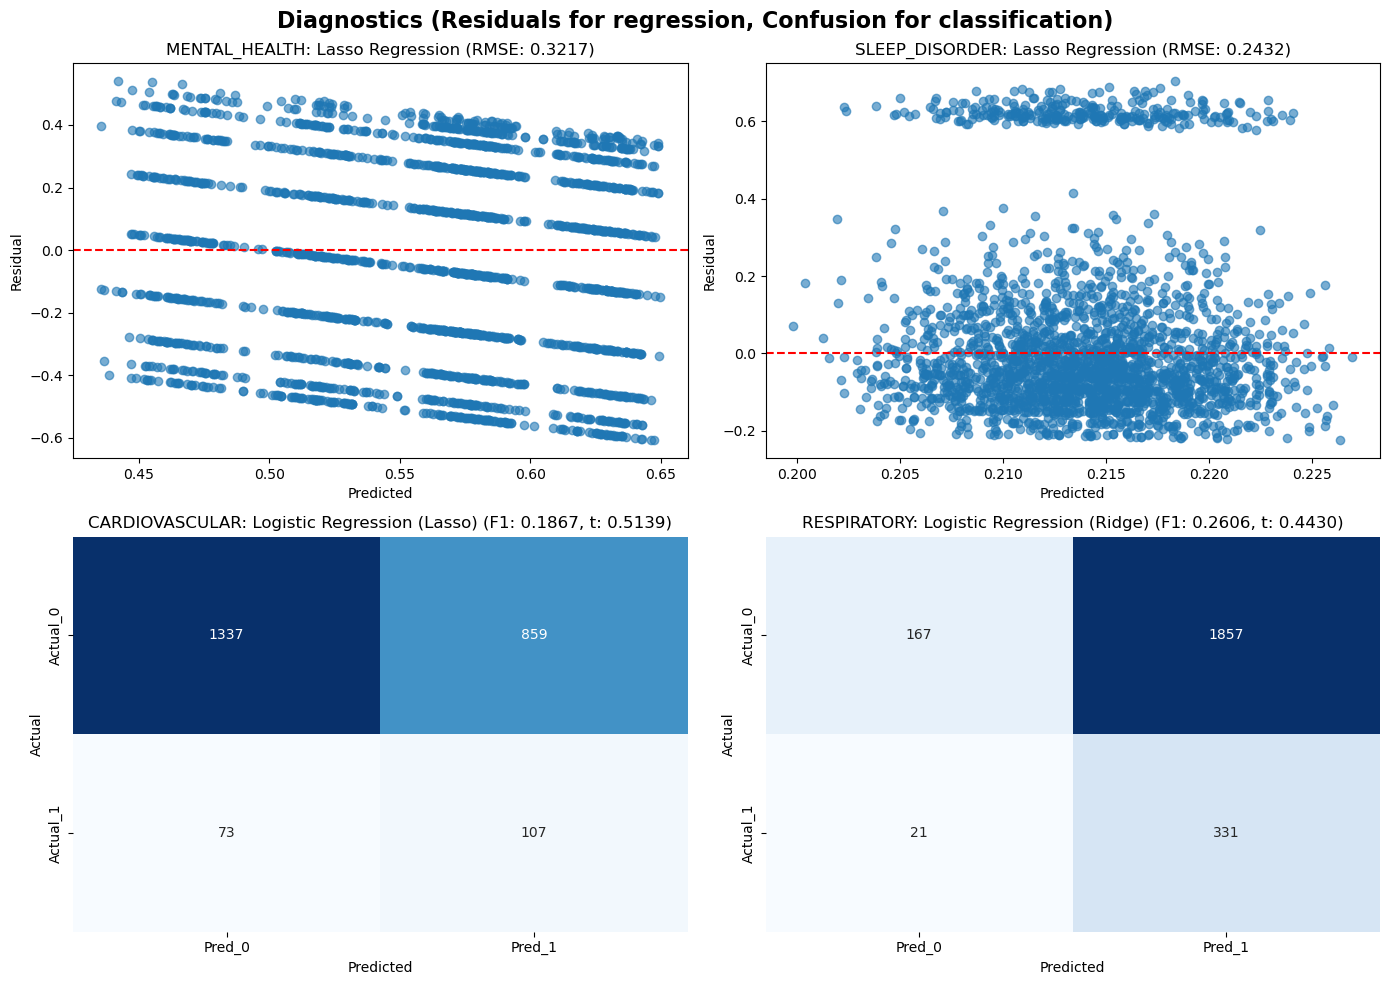

In [30]:
# Show residuals for regression datasets or confusion matrices for classification datasets in a single pass
if (all_residual_plots and not final_reg_df.empty) or (
    all_confusion_matrices and not final_clf_df.empty
):
    print("MODEL DIAGNOSTICS (Residuals or Confusion)")
    combined = []
    seen = set()

    if not final_reg_df.empty:
        for ds_name in final_reg_df["Dataset"].unique():
            combined.append(("regression", ds_name))
            seen.add(ds_name)
    if not final_clf_df.empty:
        for ds_name in final_clf_df["Dataset"].unique():
            if ds_name not in seen:
                combined.append(("classification", ds_name))
                seen.add(ds_name)

    if not combined:
        print("No diagnostics to display.")
    else:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(
            "Diagnostics (Residuals for regression, Confusion for classification)",
            fontsize=16,
            fontweight="bold",
        )
        axes = axes.flatten()

        for idx, (kind, dataset_name) in enumerate(combined):
            ax = axes[idx]

            if kind == "regression":
                dataset_results = final_reg_df[final_reg_df["Dataset"] == dataset_name]
                if dataset_results.empty:
                    ax.set_visible(False)
                    continue
                best_row = dataset_results.loc[dataset_results["RMSE"].idxmin()]
                model_name = best_row["model"]
                residuals_key = next(
                    (k for k in all_residual_plots if k.upper() == dataset_name), None
                )
                payload = all_residual_plots.get(residuals_key, {}).get(model_name)

                if payload is not None:
                    ax.scatter(payload["pred"], payload["resid"], alpha=0.6)
                    ax.axhline(0, color="red", linestyle="--")
                    ax.set_title(
                        f"{dataset_name}: {model_name} (RMSE: {best_row['RMSE']:.4f})"
                    )
                    ax.set_xlabel("Predicted")
                    ax.set_ylabel("Residual")
                else:
                    ax.text(
                        0.5, 0.5, "Residuals not available", ha="center", va="center"
                    )
                    ax.set_title(f"{dataset_name} (regression)")
            else:
                dataset_results = final_clf_df[final_clf_df["Dataset"] == dataset_name]
                if dataset_results.empty:
                    ax.set_visible(False)
                    continue
                best_row = dataset_results.loc[dataset_results["F1"].idxmax()]
                model_name = best_row["model"]
                cm_key = next(
                    (k for k in all_confusion_matrices if k.upper() == dataset_name),
                    None,
                )
                cm_df = all_confusion_matrices.get(cm_key, {}).get(model_name)

                if cm_df is not None:
                    sns.heatmap(
                        cm_df, annot=True, fmt="g", cmap="Blues", cbar=False, ax=ax
                    )
                    ax.set_title(
                        f"{dataset_name}: {model_name} (F1: {best_row['F1']:.4f}, t: {best_row['threshold']:.4f})"
                    )
                    ax.set_xlabel("Predicted")
                    ax.set_ylabel("Actual")
                else:
                    ax.text(
                        0.5,
                        0.5,
                        "Confusion matrix not available",
                        ha="center",
                        va="center",
                    )
                    ax.set_title(f"{dataset_name} (classification)")

        plt.tight_layout()
        plt.show()
else:
    print("No residuals or confusion matrices to display.")

## 8. Results

### 8.1 Most predictive features for each of the health risks

In [31]:
# Post-hoc summary: pick lowest-RMSE model per dataset (regression)
# and pick best-F1 model per dataset (classification); report feature strengths vs. mean

tol = 0.05  # 5% margin for "similar" impacts


def add_relative_strengths(coef_rows: pd.DataFrame) -> tuple[pd.DataFrame, float]:
    coef_rows = coef_rows.copy()
    coef_rows["abs_coef"] = coef_rows["coefficient"].abs()
    mean_abs = coef_rows["abs_coef"].mean()
    mean_abs = float(mean_abs) if not math.isnan(mean_abs) else 0.0
    if mean_abs == 0.0:
        coef_rows["rel_to_mean_abs"] = 0.0
    else:
        coef_rows["rel_to_mean_abs"] = coef_rows["abs_coef"] / mean_abs
    coef_rows = coef_rows.sort_values("abs_coef", ascending=False)
    return coef_rows, mean_abs


# --- Regression (uses RMSE) ---
if final_reg_df is not None and not final_reg_df.empty:
    datasets_with_rmse = final_reg_df["Dataset"].unique()
    for ds in datasets_with_rmse:
        ds_rows = final_reg_df[final_reg_df["Dataset"] == ds]
        best_row = ds_rows.loc[ds_rows["RMSE"].idxmin()]
        best_model = best_row["model"]
        best_rmse = best_row["RMSE"]
        print(f"\n=== {ds} (Regression) ===")
        print(f"Best model (lowest RMSE): {best_model} | RMSE={best_rmse:.4f}")

        coef_rows = final_coef_df[
            (final_coef_df["Dataset"] == ds) & (final_coef_df["model"] == best_model)
        ].copy()
        if coef_rows.empty:
            print("No coefficients/importances stored for this model.")
            continue

        coef_rows, mean_abs = add_relative_strengths(coef_rows)
        print(f"Mean |coef| across features: {mean_abs:.4f}")
        print("Top 5 features with relative strength (|coef| / mean |coef|):")
        display(
            coef_rows.head(5)[["feature", "coefficient", "abs_coef", "rel_to_mean_abs"]]
        )

# --- Classification (uses F1 to pick best) ---
if final_clf_df is not None and not final_clf_df.empty:
    datasets_with_clf = final_clf_df["Dataset"].unique()
    for ds in datasets_with_clf:
        ds_rows = final_clf_df[final_clf_df["Dataset"] == ds]
        best_row = ds_rows.loc[ds_rows["F1"].idxmax()]
        best_model = best_row["model"]
        best_f1 = best_row["F1"]
        print(f"\n=== {ds} (Classification) ===")
        print(f"Best model (highest F1): {best_model} | F1={best_f1:.4f}")

        coef_rows = final_coef_df[
            (final_coef_df["Dataset"] == ds) & (final_coef_df["model"] == best_model)
        ].copy()
        if coef_rows.empty:
            print("No coefficients/importances stored for this model.")
            continue

        coef_rows, mean_abs = add_relative_strengths(coef_rows)
        print(f"Mean |coef| across features: {mean_abs:.4f}")
        print("Top 5 features with relative strength (|coef| / mean |coef|):")
        display(
            coef_rows.head(5)[["feature", "coefficient", "abs_coef", "rel_to_mean_abs"]]
        )


=== MENTAL_HEALTH (Regression) ===
Best model (lowest RMSE): Lasso Regression | RMSE=0.3217
Mean |coef| across features: 0.0179
Top 5 features with relative strength (|coef| / mean |coef|):


,feature,coefficient,abs_coef,rel_to_mean_abs
24,sex,-0.215969,0.215969,12.074157
23,length_secondary_road,-0.026823,0.026823,1.499565
26,education_level,-0.024647,0.024647,1.377920
25,income,-0.010950,0.010950,0.612196
12,lst_mean,-0.007802,0.007802,0.436162



=== SLEEP_DISORDER (Regression) ===
Best model (lowest RMSE): Lasso Regression | RMSE=0.2432
Mean |coef| across features: 0.0020
Top 5 features with relative strength (|coef| / mean |coef|):


,feature,coefficient,abs_coef,rel_to_mean_abs
40,sex,-0.014999,0.014999,7.631056
35,height_varability,0.013898,0.013898,7.070576
41,income,0.006136,0.006136,3.121563
38,length_ne-sw,0.003769,0.003769,1.917532
42,education_level,-0.002475,0.002475,1.259273



=== CARDIOVASCULAR (Classification) ===
Best model (highest F1): Logistic Regression (Lasso) | F1=0.1867
Mean |coef| across features: 0.0396
Top 5 features with relative strength (|coef| / mean |coef|):


,feature,coefficient,abs_coef,rel_to_mean_abs
11,age_bin,0.390191,0.390191,9.858039
4,noisenight,0.035294,0.035294,0.891700
7,pervious_surface_cover_fraction,0.029372,0.029372,0.742072
2,no2_mean,0.011760,0.011760,0.297124
8,length_se-nw,0.005495,0.005495,0.138823



=== RESPIRATORY (Classification) ===
Best model (highest F1): Logistic Regression (Ridge) | F1=0.2606
Mean |coef| across features: 0.0252
Top 5 features with relative strength (|coef| / mean |coef|):


,feature,coefficient,abs_coef,rel_to_mean_abs
54,age_bin,0.117490,0.117490,4.659871
51,impervious_surface_cover_fraction,0.036416,0.036416,1.444333
53,length_primary_road,0.028191,0.028191,1.118110
52,length_e-w,0.026474,0.026474,1.049993
49,noisenight,0.019887,0.019887,0.788738


### Neighborhood-level risk aggregation


We now push the trained models back onto the cleaned morphology+EQ grid to get neighborhood-level risk estimates. `infer_neighborhood_health_risks` keeps typology alongside predictions so we can later slice by urban form.

In [32]:
feature_types_map = {
    dataset_name: dataset_info["feature_types"]
    for dataset_name, dataset_info in datasets.items()
}

health_risks = infer_neighborhood_health_risks(
    best_models=best_models,
    feature_types_map=feature_types_map,
    enable_ohe=ONE_HOT_ENCODING,
)

for name, df_risk in health_risks.items():
    print(f"\n{name.upper()} risk table")
    display(df_risk)


CARDIOVASCULAR risk table


,id,income,education_level,age_bin,sex,risk_cardiovascular,pc1,pc2,pc3,pc4,...,aspect_ratio,intersections,length_n-s,length_ne-sw,length_se-nw,length_e-w,length_primary_road,length_secondary_road,length_railway,neighbourhood_type
0,36,<50k,primary,Early Childhood (0-6y),M,0.134698,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
1,36,<50k,primary,Early Childhood (0-6y),F,0.134698,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
2,36,<50k,primary,Children (6-12y),M,0.183984,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
3,36,<50k,primary,Children (6-12y),F,0.183984,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
4,36,<50k,primary,Teenagers (12-18y),M,0.246172,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40315,466,>150k,tertiary,Adults (30-50y),F,0.411298,-0.472228,0.116914,-0.835083,-0.443792,...,0.232,5,285.23,360.00,215.65,28.77,0.0,889.65,0.000,S-C
40316,466,>150k,tertiary,Middle-Aged Adults (50-70y),M,0.502963,-0.472228,0.116914,-0.835083,-0.443792,...,0.232,5,285.23,360.00,215.65,28.77,0.0,889.65,0.000,S-C
40317,466,>150k,tertiary,Middle-Aged Adults (50-70y),F,0.502963,-0.472228,0.116914,-0.835083,-0.443792,...,0.232,5,285.23,360.00,215.65,28.77,0.0,889.65,0.000,S-C
40318,466,>150k,tertiary,Older Adults (70+y),M,0.594429,-0.472228,0.116914,-0.835083,-0.443792,...,0.232,5,285.23,360.00,215.65,28.77,0.0,889.65,0.000,S-C



MENTAL_HEALTH risk table


,id,income,education_level,age_bin,sex,risk_mental_health,pc1,pc2,pc3,pc4,...,aspect_ratio,intersections,length_n-s,length_ne-sw,length_se-nw,length_e-w,length_primary_road,length_secondary_road,length_railway,neighbourhood_type
0,36,<50k,primary,Early Childhood (0-6y),M,0.648633,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
1,36,<50k,primary,Early Childhood (0-6y),F,0.648633,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
2,36,<50k,primary,Children (6-12y),M,0.643281,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
3,36,<50k,primary,Children (6-12y),F,0.643281,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
4,36,<50k,primary,Teenagers (12-18y),M,0.637894,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40315,466,>150k,tertiary,Adults (30-50y),F,0.464585,-0.472228,0.116914,-0.835083,-0.443792,...,0.232,5,285.23,360.00,215.65,28.77,0.0,889.65,0.000,S-C
40316,466,>150k,tertiary,Middle-Aged Adults (50-70y),M,0.458770,-0.472228,0.116914,-0.835083,-0.443792,...,0.232,5,285.23,360.00,215.65,28.77,0.0,889.65,0.000,S-C
40317,466,>150k,tertiary,Middle-Aged Adults (50-70y),F,0.458770,-0.472228,0.116914,-0.835083,-0.443792,...,0.232,5,285.23,360.00,215.65,28.77,0.0,889.65,0.000,S-C
40318,466,>150k,tertiary,Older Adults (70+y),M,0.452966,-0.472228,0.116914,-0.835083,-0.443792,...,0.232,5,285.23,360.00,215.65,28.77,0.0,889.65,0.000,S-C



SLEEP_DISORDER risk table


,id,income,education_level,age_bin,sex,risk_sleep_disorder,pc1,pc2,pc3,pc4,...,aspect_ratio,intersections,length_n-s,length_ne-sw,length_se-nw,length_e-w,length_primary_road,length_secondary_road,length_railway,neighbourhood_type
0,36,<50k,primary,Early Childhood (0-6y),M,0.214856,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
1,36,<50k,primary,Early Childhood (0-6y),F,0.214856,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
2,36,<50k,primary,Children (6-12y),M,0.214460,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
3,36,<50k,primary,Children (6-12y),F,0.214460,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
4,36,<50k,primary,Teenagers (12-18y),M,0.214064,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40315,466,>150k,tertiary,Adults (30-50y),F,0.209057,-0.472228,0.116914,-0.835083,-0.443792,...,0.232,5,285.23,360.00,215.65,28.77,0.0,889.65,0.000,S-C
40316,466,>150k,tertiary,Middle-Aged Adults (50-70y),M,0.208668,-0.472228,0.116914,-0.835083,-0.443792,...,0.232,5,285.23,360.00,215.65,28.77,0.0,889.65,0.000,S-C
40317,466,>150k,tertiary,Middle-Aged Adults (50-70y),F,0.208668,-0.472228,0.116914,-0.835083,-0.443792,...,0.232,5,285.23,360.00,215.65,28.77,0.0,889.65,0.000,S-C
40318,466,>150k,tertiary,Older Adults (70+y),M,0.208281,-0.472228,0.116914,-0.835083,-0.443792,...,0.232,5,285.23,360.00,215.65,28.77,0.0,889.65,0.000,S-C



RESPIRATORY risk table


,id,income,education_level,age_bin,sex,risk_respiratory,pc1,pc2,pc3,pc4,...,aspect_ratio,intersections,length_n-s,length_ne-sw,length_se-nw,length_e-w,length_primary_road,length_secondary_road,length_railway,neighbourhood_type
0,36,<50k,primary,Early Childhood (0-6y),M,0.349255,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
1,36,<50k,primary,Early Childhood (0-6y),F,0.349255,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
2,36,<50k,primary,Children (6-12y),M,0.375013,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
3,36,<50k,primary,Children (6-12y),F,0.375013,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
4,36,<50k,primary,Teenagers (12-18y),M,0.401499,0.526055,0.338480,0.846051,-1.420268,...,0.391,17,112.14,420.48,83.42,561.10,0.0,1177.14,375.314,S-C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40315,466,>150k,tertiary,Adults (30-50y),F,0.474916,-0.472228,0.116914,-0.835083,-0.443792,...,0.232,5,285.23,360.00,215.65,28.77,0.0,889.65,0.000,S-C
40316,466,>150k,tertiary,Middle-Aged Adults (50-70y),M,0.502782,-0.472228,0.116914,-0.835083,-0.443792,...,0.232,5,285.23,360.00,215.65,28.77,0.0,889.65,0.000,S-C
40317,466,>150k,tertiary,Middle-Aged Adults (50-70y),F,0.502782,-0.472228,0.116914,-0.835083,-0.443792,...,0.232,5,285.23,360.00,215.65,28.77,0.0,889.65,0.000,S-C
40318,466,>150k,tertiary,Older Adults (70+y),M,0.530630,-0.472228,0.116914,-0.835083,-0.443792,...,0.232,5,285.23,360.00,215.65,28.77,0.0,889.65,0.000,S-C


In [ ]:
# let's checkout the health risks related to the neighborhood with id 36

neighborhood_id = 36
for name, df_risk in health_risks.items():
    print(f"\n{name.upper()} risk table")
    neighborhood_df = df_risk[df_risk["id"] == neighborhood_id]
    display(neighborhood_df[neighborhood_df.columns[:6]])


CARDIOVASCULAR risk table


,id,income,education_level,age_bin,sex,risk_cardiovascular
0,36,<50k,primary,Early Childhood (0-6y),M,0.134698
1,36,<50k,primary,Early Childhood (0-6y),F,0.134698
2,36,<50k,primary,Children (6-12y),M,0.183984
3,36,<50k,primary,Children (6-12y),F,0.183984
4,36,<50k,primary,Teenagers (12-18y),M,0.246172
...,...,...,...,...,...,...
163,36,>150k,tertiary,Adults (30-50y),F,0.406555
164,36,>150k,tertiary,Middle-Aged Adults (50-70y),M,0.498057
165,36,>150k,tertiary,Middle-Aged Adults (50-70y),F,0.498057
166,36,>150k,tertiary,Older Adults (70+y),M,0.589689



MENTAL_HEALTH risk table


,id,income,education_level,age_bin,sex,risk_mental_health
0,36,<50k,primary,Early Childhood (0-6y),M,0.648633
1,36,<50k,primary,Early Childhood (0-6y),F,0.648633
2,36,<50k,primary,Children (6-12y),M,0.643281
3,36,<50k,primary,Children (6-12y),F,0.643281
4,36,<50k,primary,Teenagers (12-18y),M,0.637894
...,...,...,...,...,...,...
163,36,>150k,tertiary,Adults (30-50y),F,0.459029
164,36,>150k,tertiary,Middle-Aged Adults (50-70y),M,0.453224
165,36,>150k,tertiary,Middle-Aged Adults (50-70y),F,0.453224
166,36,>150k,tertiary,Older Adults (70+y),M,0.447432



SLEEP_DISORDER risk table


,id,income,education_level,age_bin,sex,risk_sleep_disorder
0,36,<50k,primary,Early Childhood (0-6y),M,0.214856
1,36,<50k,primary,Early Childhood (0-6y),F,0.214856
2,36,<50k,primary,Children (6-12y),M,0.214460
3,36,<50k,primary,Children (6-12y),F,0.214460
4,36,<50k,primary,Teenagers (12-18y),M,0.214064
...,...,...,...,...,...,...
163,36,>150k,tertiary,Adults (30-50y),F,0.208661
164,36,>150k,tertiary,Middle-Aged Adults (50-70y),M,0.208273
165,36,>150k,tertiary,Middle-Aged Adults (50-70y),F,0.208273
166,36,>150k,tertiary,Older Adults (70+y),M,0.207886



RESPIRATORY risk table


,id,income,education_level,age_bin,sex,risk_respiratory
0,36,<50k,primary,Early Childhood (0-6y),M,0.349255
1,36,<50k,primary,Early Childhood (0-6y),F,0.349255
2,36,<50k,primary,Children (6-12y),M,0.375013
3,36,<50k,primary,Children (6-12y),F,0.375013
4,36,<50k,primary,Teenagers (12-18y),M,0.401499
...,...,...,...,...,...,...
163,36,>150k,tertiary,Adults (30-50y),F,0.456082
164,36,>150k,tertiary,Middle-Aged Adults (50-70y),M,0.483861
165,36,>150k,tertiary,Middle-Aged Adults (50-70y),F,0.483861
166,36,>150k,tertiary,Older Adults (70+y),M,0.511740


Finally, condense the neighborhood-level risks by typology to see which urban forms carry higher modeled burden across the four health dimensions. This is the quick policy-facing table for spotting resilient or vulnerable typologies.

In [34]:
# Average health risk per typology across all socio-demographic combinations (wide view)

rows = []
for name, df_risk in health_risks.items():
    risk_col = f"risk_{name}"
    if risk_col not in df_risk.columns:
        print(f"Skipping {name}: column '{risk_col}' not found.")
        continue
    grouped = (
        df_risk.groupby("typology")[risk_col]
        .mean()
        .reset_index()
        .rename(columns={risk_col: name})
    )
    rows.append(grouped)

if rows:
    combined = rows[0]
    for g in rows[1:]:
        combined = combined.merge(g, on="typology", how="outer")
    combined = combined.sort_values("typology")
    print("Average risk by typology (one column per dataset)")
    display(combined)
else:
    print("No risk data available to summarize.")

Average risk by typology (one column per dataset)


,typology,cardiovascular,mental_health,sleep_disorder,respiratory
0,A,0.352934,0.558239,0.213091,0.441699
1,B,0.350958,0.545707,0.213258,0.461661
2,C,0.354572,0.548560,0.212112,0.442824
3,D,0.348289,0.554620,0.215634,0.461400
4,E,0.349442,0.560586,0.212707,0.446127
5,F,0.358146,0.560763,0.211218,0.440759
6,G,0.348148,0.553407,0.211508,0.459964
7,I,0.342746,0.561660,0.209517,0.466731
8,J,0.359685,0.563596,0.207107,0.476070


In [35]:
# Flag typologies with elevated modeled risk per dataset (no melting)

risk_cols = [c for c in combined.columns if c != "typology"]
for col in risk_cols:
    df = combined[["typology", col]].rename(columns={col: "risk"})

    mean_risk = df["risk"].mean()
    std_risk = df["risk"].std()
    zscores = (df["risk"] - mean_risk) / std_risk if std_risk else float("nan")
    df = df.assign(zscore=zscores.round(2))

    high = df[df["zscore"] >= 1.5].sort_values("zscore", ascending=False)
    low = df[df["zscore"] <= -1.5].sort_values("zscore", ascending=True)

    print(f"\n{col.upper()} health risk")

    if not high.empty:
        print(f"\nTypologies with alarmingly higher {col} risk (z >= 1.5):")
        display(high[["typology", "risk", "zscore"]])

    if not low.empty:
        print(f"\nTypologies with exceptionally lower {col} risk (z <= -1.5):")
        display(low[["typology", "risk", "zscore"]])

    print("\nPer-typology risk with zscore: ")
    display(df.sort_values("risk", ascending=False)[["typology", "risk", "zscore"]])


CARDIOVASCULAR health risk

Typologies with alarmingly higher cardiovascular risk (z >= 1.5):


,typology,risk,zscore
8,J,0.359685,1.51



Typologies with exceptionally lower cardiovascular risk (z <= -1.5):


,typology,risk,zscore
7,I,0.342746,-1.68



Per-typology risk with zscore: 


,typology,risk,zscore
8,J,0.359685,1.51
5,F,0.358146,1.22
2,C,0.354572,0.55
0,A,0.352934,0.24
1,B,0.350958,-0.13
4,E,0.349442,-0.42
3,D,0.348289,-0.64
6,G,0.348148,-0.66
7,I,0.342746,-1.68



MENTAL_HEALTH health risk

Typologies with exceptionally lower mental_health risk (z <= -1.5):


,typology,risk,zscore
1,B,0.545707,-1.72



Per-typology risk with zscore: 


,typology,risk,zscore
8,J,0.563596,1.17
7,I,0.561660,0.86
5,F,0.560763,0.71
4,E,0.560586,0.68
0,A,0.558239,0.30
3,D,0.554620,-0.28
6,G,0.553407,-0.47
2,C,0.548560,-1.26
1,B,0.545707,-1.72



SLEEP_DISORDER health risk

Typologies with alarmingly higher sleep_disorder risk (z >= 1.5):


,typology,risk,zscore
3,D,0.215634,1.58



Typologies with exceptionally lower sleep_disorder risk (z <= -1.5):


,typology,risk,zscore
8,J,0.207107,-1.93



Per-typology risk with zscore: 


,typology,risk,zscore
3,D,0.215634,1.58
1,B,0.213258,0.60
0,A,0.213091,0.53
4,E,0.212707,0.38
2,C,0.212112,0.13
6,G,0.211508,-0.12
5,F,0.211218,-0.24
7,I,0.209517,-0.94
8,J,0.207107,-1.93



RESPIRATORY health risk

Typologies with alarmingly higher respiratory risk (z >= 1.5):


,typology,risk,zscore
8,J,0.47607,1.63



Per-typology risk with zscore: 


,typology,risk,zscore
8,J,0.476070,1.63
7,I,0.466731,0.90
1,B,0.461661,0.50
3,D,0.461400,0.48
6,G,0.459964,0.37
4,E,0.446127,-0.72
2,C,0.442824,-0.98
0,A,0.441699,-1.06
5,F,0.440759,-1.14
